# Train and test a machine learning classifier based on labeled tweets
As discussed previously, our objective is to use supervised machine learning to predict the sentiment expressed on Twitter regarding the causes for serious violent crime in London. In the previous notebook we derived hashtags that were FOR or AGAINST the London Mayor and we will now use these and their designated community classes as the basis for labeling the corpus of tweets we will use to train and then test a machine learning model. This trained model will then used to predict labels for ALL remaining tweets. The final step is to use the full body of labeled tweets as the basis for deriving the opinion of all the Twitter users.

## Context
### Feature creation
Machine learning models cannot interpret the raw text within a tweet [1] and so we therefore need to derive features based on the tweet text and convert them into numeric vectors. As discussed by Neethu and Rajasree [1], bag of words and term frequency algorithms are often used to create feature vectors and we propose using them not least because this approach was also employed by Bovet et al [3]. We summarize bag of words and term frequency below:
- Bag of words: these are the most common words used within a corpus of documents and this method can be applied to individual words and also phrases (bigrams and trigrams).
- Term frequency, Inverse Document Frequency (TF-IDF): Bag of words returns widely used words but, as discussed by Stephenson [2], a word that occurs frequently but also occurs in many documents is less useful than a less widely used word that occurs frequently in a particular document. This is because the word is more specific and therefore we can deduce its use within a document is of greater interest. 

Generating a bag of words is the first step in a TF_IDF process and so we will use both as the basis for generating features.

As discussed by Bovet et al [3], it is important to remove retweets before deriving the features because not doing so will give undue weight to the terms and phrases contained within tweets that have been retweeted many times. In addition, we also need to remove hashtags from the message text when those hashtags have been used to label the tweet. This is because the strong relationship between these hashtags and the label will unduly influence the model being trained.

### Model verification
As discussed previously, other supervised learning based opinion mining methods manually label tweets prior to training the models and we propose doing this for a subset of tweets so that we can compare the labels applied by the two models. This is a useful double check to see whether the model predictions are reasonable. 

## Method

### 1. Assign labels to tweets with relevant hashtags
Assess the labels and communities previously assigned to derive two sets of hashtags, which best represent opinions that are FOR or AGAINST the mayors reasons for serious violent crime. Then label individual tweets according to which of these hashtags they contain.

In practice, this will entail:
- Load cleaned tweets and labeled hashtags
- Compare and contrast label with community and choose appropriate hashtags
- Remove retweets and strip labeling hashtags from message text

For tweets with relevant hashtags
- Labels tweets as FOR or AGAINST based on their hashtags
- Use textual analysis (wordclouds and ngrams) to review assess message text for tweets in both camps and comment on how well they are differentiated and seperated
- Refine hashtag labeling as necessary

### 2. Derive features the train and test a tweet classifier
#### Derive Features
In broad terms, we first generate the most relevant words or phrases (bigrams) across the entire body of tweets and then create a vector for each individual tweet where the presence or absence of a particular term or phrase is indicated by a 1 or a 0 respectively. For example, if we identified 25 relevant terms then each tweet message text will be transformed to a feature vector with 25 columns containing ones or zeros.

In practice this will entail using sklearn's TfidfVectorizer function, which performs the following:
- CountVectorizer - returns a matrix of the most common words across the corpus of tweets (bag of words)
- TfidfTransformer - reduce the weight of words that are common but not specific.

We will use TfidfVectorizer to produce feature vectors for both words and bigrams. It is important to note that creating features and then training models using those features is an experimental, iterative approach. This is because we need to assess model performance in order to understand which feature combinations produce the best results. We will therefore create feature sets and run models under multiple configurations. These configurations will be as follows:
- Number of features: 50, 100
- Features derived from: words and bigrams, words only, bigrams only

The final feature set will be the one which results in the best model performance.

#### Machine learning - train and test a tweet classifier
Once we have created our feature datasets, and their associated labels, we can then perform our machine learning process. To do this we split our datasets into test and training datasets and then train the classifier using the training datasets. We then strip the labels from the test datasets and use our trained classifier to predict labels given the features in the test datasets. We then compare the predicted labels with those we had previously defined in order to determine the performance of our predictor. Performance will be measured using the same metrics as as used previously when assessing our crime machine learning classifier. These metrics are detailed below for information:
- True positive – the model correctly predicts a positive outcome
- True negative – the model correctly predicts a negative outcome
- False positive – the model predicts a positive outcome when the real outcome was negative
- False negative – the model predicts a negative outcome when the real outcome was positive
- Precision: The percentage of correctly predicted positives verses all predicted positives
- Recall: Of all positive outcomes within test dataset, how many were predicted correctly by the model
- Confusion Matrix: a matrix showing actual outcomes versus predicted outcomes and specifies the number of true positives, true negatives, false positives and false negatives
- ROC Curve and Area Under the Curve: Both reflect how good the model differentiates between our two classes. A model whose performance produces an ROC curve that is a 45% line and which has a 50% AUC has no predictive ability.

One of the benefits of using Random Forests is that the model can be used to deduce which features have the most significant impact on assigning a label. This is a very useful check and will be used to feedback into the feature selection process. 

Having identified the best feature configuration, we will then use grid search with cross validation to deduce the best hyperparameter configuration. This will be our final model and we will use this to predict the labels for unlabeled tweets in the rest of our Twitter corpus (i.e. not just the test and training dataset). 

### 3. Deriving Tweeter sentiment
Having labeled our entire body of tweets, we will then derive the sentiment of the Twitter users based on how the majority of their tweets have been labeled. This will be the output from this notebook, namely a list of Twitter users, labeled according to whether they are FOR or AGAINST the London Mayor with regard to the causes of serious violent crime.

Then merge the classified tweets with tweets previously labeled to create a single dataset, which we export for use in downstream processes

The logic is summarised in the schematic below.

<img src="notebook_logic_schematic_1_9.png">

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Assign labels to tweets with relevant hashtags
### 1.1. first load cleaned tweets and labeled hashtags

In [2]:
all_tweets_original = pd.read_csv("./DataSources/TwitterData/cleaned_tweets.csv")
print(all_tweets_original.shape)
display(all_tweets_original.head())
display(all_tweets_original.tail())

(41706, 26)


,index,tweet_id,tweet_date,tweeter_id,tweeter_user_name,tweeter_screen_name,tweeter_location,message_text,in_reply_to_user_screen_name,quote_tweet_screen_name,...,mentioned,hashtags,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_lemmatized,Clean_MessageText,tweet_date_dt,time_bins_12h,day_bins
0,0,1420355029081395203,2021-07-28 12:06:42,865262041103302656,Chris Myers,myerschrismyer1,Richmond North Yorkshire,RT @LeslieH24367191: 'Do better!' Boris Johnso...,NaN,NaN,...,[],[],Do better Boris Johnson issues scathing respo...,"['do', 'better', 'boris', 'johnson', 'issues',...","['better', 'boris', 'johnson', 'issues', 'scat...","['good', 'boris', 'johnson', 'issues', 'scathi...",good boris johnson issues scathing response sa...,2021-07-28 12:06:42,2021-07-28 12:00:00,2021-07-28 00:00:00
1,1,1420354120041615364,2021-07-28 12:03:05,229645453,Emily Sheffield,emilysheffield,London,RT @NaheedMajeed: Spot on @standardnews With L...,NaN,NaN,...,['@standardnews'],[],Spot on With London on track to break record...,"['spot', 'on', 'with', 'london', 'on', 'track'...","['spot', 'track', 'break', 'record', 'teenage'...","['spot', 'track', 'break', 'record', 'teenage'...",spot track break record teenage murdersstop se...,2021-07-28 12:03:05,2021-07-28 12:00:00,2021-07-28 00:00:00
2,2,1420351785156366337,2021-07-28 11:53:49,2843896642,Basilewitch,basilewitch,France,RT @Short2Cjs: Boris today speaking to Nick Fe...,NaN,NaN,...,[],[],Boris today speaking to Nick Ferrari about Kh...,"['boris', 'today', 'speaking', 'to', 'nick', '...","['boris', 'today', 'speaking', 'nick', 'ferrar...","['boris', 'today', 'speaking', 'nick', 'ferrar...",boris today speaking nick ferrari khan … done ...,2021-07-28 11:53:49,2021-07-28 00:00:00,2021-07-28 00:00:00
3,3,1420350419449094148,2021-07-28 11:48:23,556315551,Dean Cowcher,DeanCowcher,Bexleyheath London England,RT @LeslieH24367191: 'Do better!' Boris Johnso...,NaN,NaN,...,[],[],Do better Boris Johnson issues scathing respo...,"['do', 'better', 'boris', 'johnson', 'issues',...","['better', 'boris', 'johnson', 'issues', 'scat...","['good', 'boris', 'johnson', 'issues', 'scathi...",good boris johnson issues scathing response sa...,2021-07-28 11:48:23,2021-07-28 00:00:00,2021-07-28 00:00:00
4,4,1420349615954669574,2021-07-28 11:45:11,1267062754915090434,Alfiecat,sonya_annie,unknown,RT @Short2Cjs: Boris today speaking to Nick Fe...,NaN,NaN,...,[],[],Boris today speaking to Nick Ferrari about Kh...,"['boris', 'today', 'speaking', 'to', 'nick', '...","['boris', 'today', 'speaking', 'nick', 'ferrar...","['boris', 'today', 'speaking', 'nick', 'ferrar...",boris today speaking nick ferrari khan … done ...,2021-07-28 11:45:11,2021-07-28 00:00:00,2021-07-28 00:00:00


,index,tweet_id,tweet_date,tweeter_id,tweeter_user_name,tweeter_screen_name,tweeter_location,message_text,in_reply_to_user_screen_name,quote_tweet_screen_name,...,mentioned,hashtags,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_lemmatized,Clean_MessageText,tweet_date_dt,time_bins_12h,day_bins
41701,41701,1428283084219330566,2021-08-19 09:09:58,872173973785673728,jim._.price75,jimprice75,"Sheffield, England",RT @suemitch2017: BREAKING: Police rush to sce...,NaN,NaN,...,[],[],BREAKING Police rush to scene of horror Londo...,"['breaking', 'police', 'rush', 'to', 'scene', ...","['breaking', 'police', 'rush', 'scene', 'horro...","['breaking', 'police', 'rush', 'scene', 'horro...",breaking police rush scene horror stabbing kni...,2021-08-19 09:09:58,2021-08-19 00:00:00,2021-08-19 00:00:00
41702,41702,1428234744450387968,2021-08-19 05:57:53,985978695860019200,Dianne mary,Diannebrown128,unknown,RT @suemitch2017: BREAKING: Police rush to sce...,NaN,NaN,...,[],[],BREAKING Police rush to scene of horror Londo...,"['breaking', 'police', 'rush', 'to', 'scene', ...","['breaking', 'police', 'rush', 'scene', 'horro...","['breaking', 'police', 'rush', 'scene', 'horro...",breaking police rush scene horror stabbing kni...,2021-08-19 05:57:53,2021-08-19 00:00:00,2021-08-19 00:00:00
41703,41703,1428127105179688962,2021-08-18 22:50:09,1226457400812736512,"AnnMorton,",AnnMort92883429,unknown,RT @BTPLondon: Do you recognise these men?\n\n...,NaN,NaN,...,[],[],Do you recognise these men\n\nOfficers want t...,"['do', 'you', 'recognise', 'these', 'men', 'of...","['recognise', 'officers', 'want', 'identify', ...","['recognise', 'officers', 'want', 'identify', ...",recognise officers want identify connection st...,2021-08-18 22:50:09,2021-08-18 12:00:00,2021-08-18 00:00:00
41704,41704,1428100984920846336,2021-08-18 21:06:22,1388101054336749570,John Green,john_f_green,"London, England",Yet another stabbing in #london 😧https://t.co...,NaN,NaN,...,[],['#london'],Yet another stabbing in london 😧,"['yet', 'another', 'stabbing', 'in', 'london',...","['yet', 'another', 'stabbing', '😧']","['yet', 'another', 'stabbing', '😧']",yet another stabbing 😧,2021-08-18 21:06:22,2021-08-18 12:00:00,2021-08-18 00:00:00
41705,41705,1428007860609421327,2021-08-18 14:56:19,2728878058,Maria,MariaEW100,Worcester,RT @BTPLondon: Do you recognise these men?\n\n...,NaN,NaN,...,[],[],Do you recognise these men\n\nOfficers want t...,"['do', 'you', 'recognise', 'these', 'men', 'of...","['recognise', 'officers', 'want', 'identify', ...","['recognise', 'officers', 'want', 'identify', ...",recognise officers want identify connection st...,2021-08-18 14:56:19,2021-08-18 12:00:00,2021-08-18 00:00:00


In [3]:
hashtags = pd.read_csv("./DataSources/TwitterData/important_hashtags.csv")
print(hashtags.shape)
hashtags

display(hashtags.sort_values(by=['community_id', 'class_label'], ascending=True)[:40])
display(hashtags.sort_values(by=['community_id', 'class_label'], ascending=True)[40:])

(76, 3)


,hashtag,class_label,community_id
21,#harrow,AGAINST,0
24,#knifecrime,AGAINST,0
35,#khanage,AGAINST,0
56,#stop,AGAINST,0
68,#orpington,AGAINST,0
71,#violentcrime,AGAINST,0
73,#southlondon,AGAINST,0
74,#wokemadness,AGAINST,0
49,#austerity,FOR,0
50,#beatingcrimeplan,FOR,0


,hashtag,class_label,community_id
70,#villain,AGAINST,2
8,#arrested,AGAINST,3
12,#stabbed,AGAINST,3
36,#boys,AGAINST,3
37,#chingford,AGAINST,3
38,#death,AGAINST,3
39,#man,AGAINST,3
40,#eveningstandard,AGAINST,3
41,#found,AGAINST,3
42,#horror,AGAINST,3


### 1.2. Compare and contrast label with community and choose appropriate hashtags
- community=0: all the 'FOR' class labels fall within this community and its correct they're clustered together, particularly given this includes all the 'FOR' seed words. However, this community also contains some of the strongest AGAINST hashtags, including #knifecrime and #khanage which were among the seed words for the AGAINST classification. Maybe this community reflects the strength of the hashtags rather than their opinion but in any case do not change the class label of any of these hashtags as they seem appropriate. 
- community=1: keep #arrest, #charges and #crime as AGAINST but remove remaining labels as many are related to a crime/thriller director (Basil Dearden)
- community=2: some of these hashtags relate to a novel (judaspig) and the rest aren't really one class or another so remove except for #hydepark. Leave these in place as AGAINST for now. 
- community=3: definitely relevant, leave as AGAINST for now, maybe revisit
- community=4: AGAINST is a reasonable class label but remove #live and #freespeech as seem less relevant
- community=5: just keep #policeappeal, remove the rest
- community=6: for some reason there is no community with value = 6
- community=7: AGAINST is a reasonable class label but remove #football and #english as too generic

#### 1.2.1 Remove irrelevant hashtags

In [4]:
hashtags_to_remove = ['#judaspig',
                #     '#brutally',
                #     '#london',
                     '#eastlondon',
                     '#gangster',
                     '#judaspig',
                     '#anonymousprotectingchildrens',
                     '#hacker',
                     '#labourparty',
                     '#officer',
                     '#workfromhome',
                     '#villain',
                     '#basildearden',
                     '#eunat',
                     '#eu',
                     '#huge',
                     '#list',
                     '#law',
                     '#fiction',
                     '#th',
                     '#live',
                     '#english',
                     '#football',
                     '#freespeech',
                     '#bibleprop',
                     '#deletetheapp',
                     '#driving',
                     '#infowars']

hashtags_clean = hashtags[~hashtags.hashtag.isin(hashtags_to_remove)].copy()

hashtags_clean.sort_values(by=['class_label', 'community_id'], ascending=False)

,hashtag,class_label,community_id
49,#austerity,FOR,0
50,#beatingcrimeplan,FOR,0
51,#borisjohnson,FOR,0
52,#policecuts,FOR,0
53,#racism,FOR,0
54,#stopandsearch,FOR,0
55,#racistengland,FOR,0
26,#sadiqkhan,AGAINST,7
28,#londonmayor,AGAINST,7
72,#woke,AGAINST,7


#### 1.2.2 Create sets containing FOR and AGAINST hashtags

In [5]:
for_hashtags = hashtags_clean['hashtag'][hashtags_clean.class_label == 'FOR'].to_list()
against_hashtags = hashtags_clean['hashtag'][hashtags_clean.class_label == 'AGAINST'].to_list()

set_for = set(for_hashtags)
set_against = set(against_hashtags)

### 1.3 Remove retweets and strip labeling hashtags from message text
As discussed previously, retweets with skew our features and so we need to remove them.

#### 1.3.1 Remove retweets

In [6]:
display(all_tweets_original.shape)
all_tweets = all_tweets_original[all_tweets_original.is_retweet == 'N'].copy().reset_index()
display(all_tweets.shape)
display(all_tweets.head())
display(all_tweets.tail())

(41706, 26)

(11873, 27)

,level_0,index,tweet_id,tweet_date,tweeter_id,tweeter_user_name,tweeter_screen_name,tweeter_location,message_text,in_reply_to_user_screen_name,...,mentioned,hashtags,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_lemmatized,Clean_MessageText,tweet_date_dt,time_bins_12h,day_bins
0,5,5,1420349249661853697,2021-07-28 11:43:44,1338186814448922625,Oliver Steinmetz,OliverSteinme16,unknown,@Bravescott69 @Kalimeralynn I am totally agree...,Bravescott69,...,"['@Bravescott69', '@Kalimeralynn']",[],I am totally agree with him that Khan must a...,"['i', 'am', 'totally', 'agree', 'with', 'him',...","['totally', 'agree', 'khan', 'act', 'crackdown...","['totally', 'agree', 'khan', 'act', 'crackdown...",totally agree khan act crackdown knife crime r...,2021-07-28 11:43:44,2021-07-28 00:00:00,2021-07-28 00:00:00
1,8,8,1420345735799791620,2021-07-28 11:29:46,257934901,Eilidh,bramble__jam,Dublin,A lot of the time when non-londonders make lit...,NaN,...,[],[],A lot of the time when nonlondonders make litt...,"['a', 'lot', 'of', 'the', 'time', 'when', 'non...","['lot', 'time', 'nonlondonders', 'make', 'litt...","['lot', 'time', 'nonlondonders', 'make', 'litt...",lot time nonlondonders make little jokes knife...,2021-07-28 11:29:46,2021-07-28 00:00:00,2021-07-28 00:00:00
2,10,10,1420345177911267330,2021-07-28 11:27:33,1359171603205128194,Daniel Cindrem,John27454952,unknown,@linmeitalks Let's be honest. The majority of ...,linmeitalks,...,['@linmeitalks'],[],Lets be honest The majority of knife crime in...,"['lets', 'be', 'honest', 'the', 'majority', 'o...","['lets', 'honest', 'majority', 'knife', 'crime...","['lets', 'honest', 'majority', 'knife', 'crime...",lets honest majority knife crime committed bla...,2021-07-28 11:27:33,2021-07-28 00:00:00,2021-07-28 00:00:00
3,21,21,1420339262516563970,2021-07-28 11:04:03,706903864,mrsthatcher,527_thatch,"Brighton, England",Most of the Country think you should concentra...,NaN,...,[],[],Most of the Country think you should concentra...,"['most', 'of', 'the', 'country', 'think', 'you...","['country', 'think', 'concentrate', 'ending', ...","['country', 'think', 'concentrate', 'ending', ...",country think concentrate ending knife crime s...,2021-07-28 11:04:03,2021-07-28 00:00:00,2021-07-28 00:00:00
4,25,25,1420338014031654913,2021-07-28 10:59:05,1113121490315198466,CallyJ,Short2Cjs,unknown,Boris today speaking to Nick Ferrari about Kha...,NaN,...,[],[],Boris today speaking to Nick Ferrari about Kha...,"['boris', 'today', 'speaking', 'to', 'nick', '...","['boris', 'today', 'speaking', 'nick', 'ferrar...","['boris', 'today', 'speaking', 'nick', 'ferrar...",boris today speaking nick ferrari khan … done ...,2021-07-28 10:59:05,2021-07-28 00:00:00,2021-07-28 00:00:00


,level_0,index,tweet_id,tweet_date,tweeter_id,tweeter_user_name,tweeter_screen_name,tweeter_location,message_text,in_reply_to_user_screen_name,...,mentioned,hashtags,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_lemmatized,Clean_MessageText,tweet_date_dt,time_bins_12h,day_bins
11868,41669,41669,1429022268143947776,2021-08-21 10:07:13,1425537126704324610,Recharge⚡,7_recharge,UK,@DeclandThomas06 @stephenkeane233 @TheReal0363...,DeclandThomas06,...,"['@DeclandThomas06', '@stephenkeane233', '@The...",[],The public is London is now well know as a...,"['the', 'public', 'is', 'london', 'is', 'now',...","['public', 'well', 'know', 'stabbing…']","['public', 'well', 'know', 'stabbing…']",public well know stabbing…,2021-08-21 10:07:13,2021-08-21 00:00:00,2021-08-21 00:00:00
11869,41672,41672,1429016036800704513,2021-08-21 09:42:27,2189056412,Commodity Hunter #MBGA,BermudaBat,"England, United Kingdom",The #Khanage continues..\n\nLondon murder prob...,NaN,...,[],['#khanage'],The Khanage continues\n\nLondon murder probe a...,"['the', 'khanage', 'continues', 'london', 'mur...","['khanage', 'continues', 'murder', 'probe', 's...","['khanage', 'continues', 'murder', 'probe', 's...",khanage continues murder probe stabbed chest b...,2021-08-21 09:42:27,2021-08-21 00:00:00,2021-08-21 00:00:00
11870,41673,41673,1429013785965105152,2021-08-21 09:33:31,590147379,UK News in Pictures (@UKNIP247),uknip247,United Kingdom,"Police were called at 3.45am on Saturday, 21 A...",NaN,...,[],[],Police were called at am on Saturday August t...,"['police', 'were', 'called', 'at', 'am', 'on',...","['police', 'called', 'saturday', 'august', 're...","['police', 'called', 'saturday', 'august', 're...",police called saturday august reports disturba...,2021-08-21 09:33:31,2021-08-21 00:00:00,2021-08-21 00:00:00
11871,41677,41677,1428972448733614080,2021-08-21 06:49:15,198818760,Cristian Nord,CristianNord,..RSA..,man stabbed for hat and bag during terrifying ...,NaN,...,[],['#london'],man stabbed for hat and bag during terrifying ...,"['man', 'stabbed', 'for', 'hat', 'and', 'bag',...","['stabbed', 'hat', 'bag', 'terrifying', 'attac...","['stabbed', 'hat', 'bag', 'terrifying', 'attac...",stabbed hat bag terrifying attack tube station...,2021-08-21 06:49:15,2021-08-21 00:00:00,2021-08-21 00:00:00
11872,41704,41704,1428100984920846336,2021-08-18 21:06:22,1388101054336749570,John Green,john_f_green,"London, England",Yet another stabbing in #london 😧https://t.co...,NaN,...,[],['#london'],Yet another stabbing in london 😧,"['yet', 'another', 'stabbing', 'in', 'london',...","['yet', 'another', 'stabbing', '😧']","['yet', 'another', 'stabbing', '😧']",yet another stabbing 😧,2021-08-18 21:06:22,2021-08-18 12:00:00,2021-08-18 00:00:00


#### Comments on removing retweets
Removing retweets reduces the original dataset by nearly 75% so we are left with just 12,000 tweets. It's clear this is an important step as without it we would have around 30,000 tweets giving greater weight to relatively few words.

#### 1.3.2 Strip hashtags from message text
We need to be careful when stripping hashtags from clean message text because the message text could have contained the same words as used in a hashtag but as text on its own, rather than as a hashtag. Therefore, we only process tweets which also have hashtags and then only strip words from the tweet if that word ALSO exists in the list of hashtags associated with the tweet (this logic was tested against test data and the results are shown in Appendix B)

In [7]:
from nltk.tokenize import word_tokenize

def string_to_list_hash(my_str):
    delimiter = ","
    my_str = my_str.replace("[", "")
    my_str = my_str.replace("]", "")
    my_str = my_str.replace("'", "")
    my_str = my_str.replace(" ", "")
    my_str = my_str.replace("#", "")
    my_list = my_str.split(delimiter)
    return my_list


def remove_label_hashtags(text, hashtags, ignore_words):
    
    if len(hashtags) == 2 : # a tweet with no hashtags contains [] and so len==2 means no hashtags
        pruned_text = text
    else:
        my_hashtags = string_to_list_hash(hashtags) # turns hashtag string into a list and removes the '#' symbol
        
        # create a list of all hashtag words in this tweet that are also in our ignore words 
        # influenced by https://www.kite.com/python/answers/how-to-find-common-elements-between-two-lists-in-python
        
        my_hashtags_as_set = set(my_hashtags)
        intersection = my_hashtags_as_set.intersection(ignore_words)
        ignore_list = list(intersection)
        
        if len(ignore_list) == 0:
            pruned_text = text
        else:
            tokenized_text = word_tokenize(text)
            pruned_text_list = [w for w in tokenized_text if not w in ignore_list]
            pruned_text = ' '.join([w for w in pruned_text_list])
        
    return pruned_text


ignore_hashtags_set = set_for.union(set_against) # create a single set containing all hashtags

ignore_hashtags = list(ignore_hashtags_set) # turn set into a list
ignore_words = [w[1:] for w in ignore_hashtags] # create a list of ignore words which are hashtags but without the '#' 

print("Number of items in set_for: {}, number in set_against: {} and in the combined list: {}".format(len(set_for),
                                                                                                    len(set_against),
                                                                                                    len(ignore_words)))

all_tweets['Clean_MessageText_refined'] = all_tweets.apply(lambda x: remove_label_hashtags(x['Clean_MessageText'], 
                                                                                                x['hashtags'], ignore_words), 
                                                                                                 axis=1)

all_tweets.head()

Number of items in set_for: 7, number in set_against: 44 and in the combined list: 51


,level_0,index,tweet_id,tweet_date,tweeter_id,tweeter_user_name,tweeter_screen_name,tweeter_location,message_text,in_reply_to_user_screen_name,...,hashtags,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_lemmatized,Clean_MessageText,tweet_date_dt,time_bins_12h,day_bins,Clean_MessageText_refined
0,5,5,1420349249661853697,2021-07-28 11:43:44,1338186814448922625,Oliver Steinmetz,OliverSteinme16,unknown,@Bravescott69 @Kalimeralynn I am totally agree...,Bravescott69,...,[],I am totally agree with him that Khan must a...,"['i', 'am', 'totally', 'agree', 'with', 'him',...","['totally', 'agree', 'khan', 'act', 'crackdown...","['totally', 'agree', 'khan', 'act', 'crackdown...",totally agree khan act crackdown knife crime r...,2021-07-28 11:43:44,2021-07-28 00:00:00,2021-07-28 00:00:00,totally agree khan act crackdown knife crime r...
1,8,8,1420345735799791620,2021-07-28 11:29:46,257934901,Eilidh,bramble__jam,Dublin,A lot of the time when non-londonders make lit...,NaN,...,[],A lot of the time when nonlondonders make litt...,"['a', 'lot', 'of', 'the', 'time', 'when', 'non...","['lot', 'time', 'nonlondonders', 'make', 'litt...","['lot', 'time', 'nonlondonders', 'make', 'litt...",lot time nonlondonders make little jokes knife...,2021-07-28 11:29:46,2021-07-28 00:00:00,2021-07-28 00:00:00,lot time nonlondonders make little jokes knife...
2,10,10,1420345177911267330,2021-07-28 11:27:33,1359171603205128194,Daniel Cindrem,John27454952,unknown,@linmeitalks Let's be honest. The majority of ...,linmeitalks,...,[],Lets be honest The majority of knife crime in...,"['lets', 'be', 'honest', 'the', 'majority', 'o...","['lets', 'honest', 'majority', 'knife', 'crime...","['lets', 'honest', 'majority', 'knife', 'crime...",lets honest majority knife crime committed bla...,2021-07-28 11:27:33,2021-07-28 00:00:00,2021-07-28 00:00:00,lets honest majority knife crime committed bla...
3,21,21,1420339262516563970,2021-07-28 11:04:03,706903864,mrsthatcher,527_thatch,"Brighton, England",Most of the Country think you should concentra...,NaN,...,[],Most of the Country think you should concentra...,"['most', 'of', 'the', 'country', 'think', 'you...","['country', 'think', 'concentrate', 'ending', ...","['country', 'think', 'concentrate', 'ending', ...",country think concentrate ending knife crime s...,2021-07-28 11:04:03,2021-07-28 00:00:00,2021-07-28 00:00:00,country think concentrate ending knife crime s...
4,25,25,1420338014031654913,2021-07-28 10:59:05,1113121490315198466,CallyJ,Short2Cjs,unknown,Boris today speaking to Nick Ferrari about Kha...,NaN,...,[],Boris today speaking to Nick Ferrari about Kha...,"['boris', 'today', 'speaking', 'to', 'nick', '...","['boris', 'today', 'speaking', 'nick', 'ferrar...","['boris', 'today', 'speaking', 'nick', 'ferrar...",boris today speaking nick ferrari khan … done ...,2021-07-28 10:59:05,2021-07-28 00:00:00,2021-07-28 00:00:00,boris today speaking nick ferrari khan … done ...


### 1.4 Now classify tweets according to which class the majority of their hashtags fall into

#### 1.4.1 Classify tweets
I will be comparing the hashtags within a single tweet with the for and against hashtag lists and summing the number of matches to identify whether the tweet is predominately for or against the mayor. I will use pandas 'sets' and its difference function to do this. This was inspired by https://www.stechies.com/compare-lists-python-using-set-cmp-function/

In Appendix A we test the following functions with dummy data to prove they work as expected

In [8]:
def string_to_list(my_str):
    delimiter = ","
    my_str = my_str.replace("[", "")
    my_str = my_str.replace("]", "")
    my_str = my_str.replace("'", "")
    my_str = my_str.replace(" ", "")
    my_list = my_str.split(delimiter)
    return my_list

def get_tweet_class(hashtags, set_for, set_against):

    class_value = 'NONE'
    
    if len(hashtags) > 2 : # a tweet with no hashtags contains [] and so len==2 means no hashtags
        
        class_value = 'HAS_HASHTAG'
        
        hashtags_in_tweet = string_to_list(hashtags)
        set_hashtags = set(hashtags_in_tweet)

        # take intersections of two lists                
        for_test = set_for.intersection(set_hashtags)
        against_test = set_against.intersection(set_hashtags)
    
        # check if any matches with our for/against lists 
        if (len(against_test) > 0) | (len(for_test) > 0):
                        
            #there is at least one match, now test which matches more closely
            if len(against_test) > len(for_test):
                class_value = 'AGAINST'
            else:
                class_value = 'FOR'
        
    return class_value

In [9]:
all_tweets['label'] = '' 
all_tweets['label'] = all_tweets['hashtags'].apply(lambda x: get_tweet_class(x, set_for, set_against))

all_tweets_count = all_tweets['label'].count()
no_tag_count = all_tweets['label'][all_tweets.label == 'NONE'].count()
no_tag_pct = no_tag_count/all_tweets_count
for_count = all_tweets['label'][all_tweets.label == 'FOR'].count()
for_pct = for_count / all_tweets_count
against_count = all_tweets['label'][all_tweets.label == 'AGAINST'].count()
against_pct = against_count / all_tweets_count
other_tag_count = all_tweets['label'][all_tweets.label == 'HAS_HASHTAG'].count()
other_tag_pct = other_tag_count / all_tweets_count

print("Out of a total of {:,} tweets, we have the following classifications:\nNO HASHTAG: {:,} ({:.1%})\nAGAINST: {} ({:.1%})\nFOR: {} ({:.1%})\nOther Hashtag: {} ({:.1%})".format(all_tweets_count, 
                                                                                                                                        no_tag_count, no_tag_pct,
                                                                                                                                        against_count, against_pct, 
                                                                                                                                        for_count, for_pct,
                                                                                                                                        other_tag_count, other_tag_pct))

Out of a total of 11,873 tweets, we have the following classifications:
NO HASHTAG: 10,951 (92.2%)
AGAINST: 410 (3.5%)
FOR: 12 (0.1%)
Other Hashtag: 500 (4.2%)


#### Comments 
Less than 10% of our tweets have any hashtag and of those only 3.5% have hashtags we can use to classify our tweets. This is a disappointing return particularly given Bovet et al [2] describe having a large number of opinion hashtags (and polarisation in their usage) as strong pre conditions for their method being successful.

In addition, we have approximately 400 tweets in the AGAINST class but too few in the FOR class to be able to use these tweets on their own as the basis for the other label in our classification. We could use SMOTE as we did previously but oversampling so few tweets dramatically increases the likelyhood of an overfitted model. We therefore propose creating the FOR tweets population by taking all FOR tweets plus a random sample of other tweets which have been labeled HAS_HASHTAG.  


In [10]:
col_list = ['tweet_id',
           'tweeter_screen_name',
           'hashtags',
           'Tweet_lemmatized',
           'Clean_MessageText',
           'Clean_MessageText_refined',
           'label']

against_tweets = all_tweets[col_list][all_tweets.label == 'AGAINST']
against_tweets['target'] = 1

# get all FOR tweets
for_tweets = all_tweets[col_list][all_tweets.label == 'FOR']
# now fill up with other hashtags
other_hashtag_count = against_count - for_count
other_hashtag_tweets = all_tweets[col_list][all_tweets.label == 'HAS_HASHTAG'].sample(n=other_hashtag_count)

frames = [for_tweets, other_hashtag_tweets]

not_against_tweets = pd.concat(frames)
not_against_tweets['target'] = 0

pruned_tweets = pd.concat([against_tweets, not_against_tweets]).reset_index(drop=True)
pruned_tweets.drop('label', axis=1, inplace=True)

print("against_count: {}, for_count: {}, other_hashtag_count: {}".format(against_count, for_count, other_hashtag_count))
print("pruned_tweets shape: {}".format(pruned_tweets.shape))

against_count: 410, for_count: 12, other_hashtag_count: 398
pruned_tweets shape: (820, 7)


#### 1.4.2 Analyse the words and phrases used in the newly labeled tweets
We now use word clouds and word/bigram plots to see which words are most commonly used in each of our two populations. If the hashtags are good at seperating the populations then we would expect to see each population emphasising different words and phrases

In [11]:
import twitter_NLP_functions as tw_nlp

Loading BokehJS ...

In [12]:
all_clean_words_for = " ".join(ttext for ttext in pruned_tweets[pruned_tweets.target==0]['Clean_MessageText_refined']) # code taken from VA_Lab08 (Text)
all_clean_words_against = " ".join(ttext for ttext in pruned_tweets[pruned_tweets.target==1]['Clean_MessageText_refined']) # code taken from VA_Lab08 (Text)

unique_for = tw_nlp.unique_words(all_clean_words_for)
unique_against = tw_nlp.unique_words(all_clean_words_against)

print("Number of words, FOR = " + str(len(unique_for))) # we have 462922 unique words
print("Number of words, AGAINST = " + str(len(unique_against))) 

Number of words, FOR = 2060
Number of words, AGAINST = 1599



 ----------- ALL WORDS - FOR ---------- 



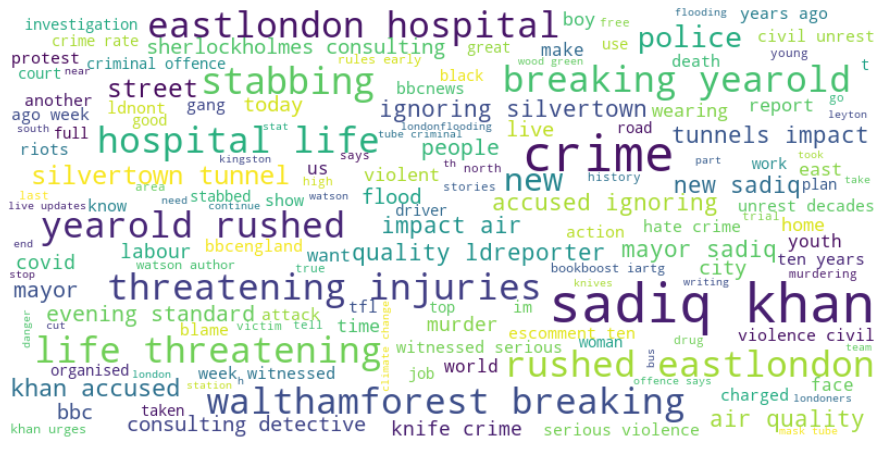


 ----------- ALL WORDS - AGAINST ---------- 



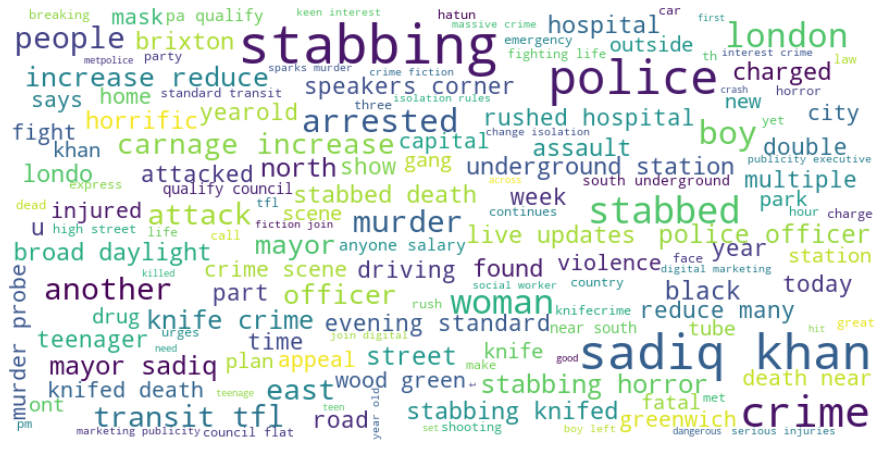

In [13]:
tw_nlp.plot_wordcloud(all_clean_words_for, 'ALL WORDS - FOR')
tw_nlp.plot_wordcloud(all_clean_words_against, 'ALL WORDS - AGAINST')

#### Comments
Sadiq Khan and crime are important in both populations which doesn't suggest good separation, though stabbing/stabbed are far more prominent in the against population. The overlap isn't surprising given the FOR population was padded with more generic hashtags.

Now lets use word and ngram plots to investigate further

In [14]:
tw_nlp.plot_ngrams(pruned_tweets[pruned_tweets.target==0], 'Clean_MessageText_refined')

In [15]:
tw_nlp.plot_ngrams(pruned_tweets[pruned_tweets.target==1], 'Clean_MessageText_refined')

#### Comments
Again, stabbing and stabbed feature more prominently in the AGAINST population but crime, sadiq and khan feature prominently in both populations and this confirms what we saw in the word clouds. 

Tweets within the FOR and AGAINST classes use very similar words in the body of the text and this means the features we create from them (bag of words, count vectorizer) will be similar too. This is likely to impact the performance of our classifier. This problem arises because less than 10% of our tweets contain any hashtags at all and only 3.5% contained hashtags that can be used to classify tweets. This is exacerbated because the number of hashtags used to classify FOR tweets was negligible and so at best we can train a classifier to predict AGAINST or NOT AGAINST, we cannot train a classifier to predict FOR the mayor. This is itself is an interesting finding.  

Before progressing, it's worth double checking the words used in the message text of tweets which we'd originally classified as supporting the Mayor. This could help us understand whether our problem arises from having to randomly select tweets

In [ ]:
all_clean_words_for_hash = " ".join(ttext for ttext in all_tweets[all_tweets.label == 'FOR']['Clean_MessageText_refined']) # code taken from VA_Lab08 (Text)

tw_nlp.plot_wordcloud(all_clean_words_for_hash, 'ALL WORDS - FOR, from hashtags')

unique_for_hash = tw_nlp.unique_words(all_clean_words_for_hash)

print("Number of words, FOR, from hashtags = " + str(len(unique_for_hash)))

In [ ]:
tw_nlp.plot_ngrams(all_tweets[all_tweets.label == 'FOR'], 'Clean_MessageText_refined')

THe NGRAM plots show crime, plan and beating crime featuring more prominently and so there is 'some' difference in the words used in those classified as FOR tweets. This suggests we could have had more success if we'd identified a greater number of tweets using hashtags which openly supported the Mayors position. This means that we confirm Bovet's original conclusion that for his classification process to work we need 'a large usage of opinion-hashtags and a polarization of opinion resulting in well seperated hashtag clusters'.


### 1.5 Conclusions 
Removing retweets reduced the available tweets substantially but the biggest impact is the low proportion of tweets containing hashtags which we can used to label he tweets. This is exacerbated by the negligible number of tweets with hashtags that fall into the FOR camp. In effect, we don't have a FOR camp just a 'NOT AGAINST' camp and the knock on effect is that the words used in tweets in both camps do not appear to be substantially different. The main exception to this are the words stabbed and stabbing, which only feature prominently in the AGAINST camp.

We hypothesise at this stage that this will have a detrimental impact on the performance of our model because the features are generated using the words in the tweet message text but we will now confirm or refute this.

## 2 Derive features the train and test a tweet classifier
As discussed previously, the model is trained using features derived from the message text and the features used should be informed by how well the model performs. This means the two are inextricably linked and need to be done together.

Our broad approach is to create a set of features with different configurations, run the model to see how they perform, amend the configuration and repeat until we have the best performing model. As discussed before, the starting feature combinations will be as follows:
- number of features, n: 50, 100
- feature characteristics: words and bigrams, just words, just bigrams.

For the best performing model, we will then analyse feature performance and tweak features before running it again. If this model performs better then this will be taken as the prefered option to take forward. We will then use a grid search to identify the best hyperparameter configuration for this model. 

### 2.1 Helper Functions

#### 2.2.1 Feature helpers
- 1. First create our document corpus, which will result in one document for each tweet's message text
- 2. Then create numeric matrices to represent the word and ngram features - This code was inspired by user guide and examples https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
    - These vectors will be produced using the sklearn TfidfTransformer function, which is equivalent to calling CountVectorizer followed by TfidfTransformer - count vectorizer purely returns a matrix of which common words are present but tfid reduces the weight of words that are common across many documents in order to focus only on words that are common AND specific to our documents. THis reduces noise.
    - Bovet et al [3] used hashtags among their features but we know a large number of our tweets don't contain them so will create features purely on words and phrases

#### 2.2.2 Machine learning helpers
We use a Random Forest machine learning model as before and the training and performance metric processes are wrapped in a single function, called get_features_and_labels(..). This in turn is called by the run_scenario(..) function, which wraps the feature creation, machine learning training, testing and performance measurement in a single method so that we can repeatedly call it using different feature parameters.

#### Notes
It should be noted that this code was inspired by Bovet notebooks but mostly to inform and/or confirm the method rather than to  reuse specific code. The notebooks referenced in this way were as follows:
- https://github.com/alexbovet/network_lesson/blob/master/04_Twitter_Sentiment_Analysis.ipynb
- https://github.com/alexbovet/network_lesson/blob/master/TwSentiment.py
- https://github.com/alexbovet/network_lesson/blob/master/train_sentiment_classifier.py

In [16]:
#from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import MachineLearning_functions as ml_performance

from enum import Enum
   
# create our dictionary of words and ngrams
def get_words_ngrams(message_text, n):
    
    common_words = tw_nlp.get_top_n_words(message_text, n)
    common_ngrams = tw_nlp.get_top_k_n_gram(message_text, n,2)

    words_vocab = [word_tup[0] for word_tup in common_words]
    ngrams_vocab = [bigram_tup[0] for bigram_tup in common_ngrams]
    
    return words_vocab, ngrams_vocab

def get_word_features(words_vocab, corpus):

    #vectorizer = CountVectorizer(vocabulary=words_vocab)
    vectorizer = TfidfVectorizer(vocabulary=words_vocab)
    X = vectorizer.fit_transform(corpus)
    print("shape of words array = {}".format(X.shape))
    
    column_names_words = vectorizer.get_feature_names()
    words_array = X.toarray()
    
    df_individual_words = pd.DataFrame(data=words_array, columns=column_names_words)
    
    return df_individual_words

def get_bigram_features(ngrams_vocab, corpus):

    #vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2), vocabulary=ngrams_vocab)
    vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), vocabulary=ngrams_vocab)
    X = vectorizer.fit_transform(corpus)
    print("shape of bigrams array = {}".format(X.shape))

    column_names = vectorizer.get_feature_names()
    bigram_array = X.toarray()
    
    df_ngrams = pd.DataFrame(data=bigram_array, columns=column_names)
    
    return df_ngrams

features_mode = Enum('features_mode', 'DEFAULT WORDS BIGRAMS')

def get_features_and_labels(tweets, df_individual_words, df_ngrams, myMode=features_mode.DEFAULT, printFile='N'):
    
    # first create the labels - I also include Tweet_lemmatised field so I can 
    # manually sense check my created dataset in excel if I choose to print the file
    
    labels = tweets[['target', 'Tweet_lemmatized']]
    df_labels = pd.DataFrame(data=labels, columns=['target', 'Tweet_lemmatized'])
    
    if myMode == features_mode.DEFAULT:
        # default is to combine words and bigrams
        print("<------- features created from both WORDS and BIGRAMS ------>")
        df_all_data = df_ngrams.join(df_labels)
        df_all_data = df_all_data.join(df_individual_words)
        
    else:
        if myMode == features_mode.WORDS:
            # words only
            print("<------- features created from WORDS only ---------->")
            df_all_data = df_individual_words.join(df_labels)
        else:
            # bigrams only
            print("<------- features created from BIGRAMS only ---------->")
            df_all_data = df_ngrams.join(df_labels)

    print("shape of df_all_data = {}".format(df_all_data.shape))
    print("\n <----- First 2 rows of df_all_data ----->")
    display(df_all_data.head(2))
    
    if printFile=='Y':
        df_all_data.to_csv('./DataSources/TwitterData/twitter_features.csv', index=False)
        
    labels = np.array(df_all_data['target'])
    df_all_data = df_all_data.drop(['target', 'Tweet_lemmatized'], axis = 1)
    features = np.array(df_all_data)

    print("shape of labels = {}".format(labels.shape))
    print("shape of features = {}".format(features.shape))
        
    return features, labels, df_all_data

def train_and_test_classifier(features, labels):
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)
    
    print('Training Features Shape:', train_features.shape)
    print('Training Labels Shape:', train_labels.shape)
    print('Testing Features Shape:', test_features.shape)
    print('Testing Labels Shape:', test_labels.shape)
    
    rf = RandomForestClassifier(n_estimators = 500, oob_score = True,
                           bootstrap = True, random_state = 42)

    # Train the model on training data
    rf.fit(train_features, train_labels);
    
    # Use the forest's predict method on the test data
    predictions = rf.predict(test_features)
    
    # print hyperparameters used as a baseline for when we do the grid search later
    parameters_used = rf.get_params()
    print("\n------------------ parameters used -------------------\n")
    print(parameters_used)
    print("\n")
    
    accuracy, precision, recall, roc_auc, tn, fp, fn, tp = ml_performance.RF_performance_reporting(rf, test_features, test_labels, 
                                                                                predictions, 'normal', print_output=True)
    
    return accuracy, precision, recall, roc_auc, tn, fp, fn, tp, rf
    

def run_scenario(description, tweets, corpus, n, myMode=features_mode.WORDS, printFile='N'):
    
    words_vocab, ngrams_vocab = get_words_ngrams(tweets.Clean_MessageText_refined, n)
    df_individual_words = get_word_features(words_vocab, corpus)
    df_ngrams = get_bigram_features(ngrams_vocab, corpus)

    print("<-------------- common words ------------------>")
    print("common words, row count: {} ".format(df_individual_words.shape[0]))
    display(df_individual_words.head(2))
    print("<-------------- common bigrams ------------------>")
    print("common bigrams, row count: {} ".format(df_ngrams.shape[0]))
    display(df_ngrams.head(2))
    
    # features_modes: if both, then DEFAULT, if just words then WORDS, if just bigrams then BIGRAMS
    features, labels, df_all_data = get_features_and_labels(tweets, df_individual_words, df_ngrams, 
                                           myMode, printFile)
    
    accuracy, precision, recall, roc_auc, tn, fp, fn, tp, rf = train_and_test_classifier(features, labels)
    
    rf_result_row = {'description': description, 
                 'accuracy': accuracy, 
                 'precision': precision,
                 'recall': recall,
                 'auc': roc_auc, 
                 'true positive': tp, 
                 'false positive': fp, 
                 'true negative': tn, 
                 'false negative': fn}
    
    return rf_result_row, rf, df_all_data

### 2.2. Create the document corpus
This is a list of 'documents', where 1 document = 1 tweets message text 
- we use the refined text so that we do not include labelling hashtags

In [17]:
def get_corpus(tweets):

    corpus =[]
  
    # Iterate over each row
    for row in tweets.itertuples():
    
        # append the list to the final list
        corpus.append(row.Clean_MessageText_refined)
  
    # Print the corpus
    print("The document corpus has length: {}".format(len(corpus)))
    print("<----------------- corpus -------------->")
    display(corpus[:5])
    display(corpus[-5:])

    print("\n<--------- original tweets ------------->")
    # display original DF so we can confirm they are the same
    print("The tweet dataframe has length: {}".format(tweets.Clean_MessageText_refined.count()))
    display(tweets.Clean_MessageText_refined.head(5))
    display(tweets.Clean_MessageText_refined.tail(5))
    
    return corpus

corpus = get_corpus(pruned_tweets)

The document corpus has length: 820
<----------------- corpus -------------->


['seriously injured stabbing teen girl woman charged police hortonandwellington knife…',
 '’ six years ’ sadiq khan lambasted knife surge sadiq khan grilled calle…',
 'fallen low total five years',
 '’ six years ’ lambasted knife crime surge continues und…',
 'city hit night violence leaving dead hospital hit three shocking k…']

['riotstenyearson ‘ potentially wasted decade ’ address underlying causes riots…',
 'labour mp denies cheating taxpayers £k council home apsana begum trial begin…',
 'bikestormz antiknife crime movement knivesdownbikesup mass rideout saturday july starting southwark pa…',
 'afgan asylumseeker refugee greatbritain🇬🇧 samiulahaq akbari stalked english speakin…',
 'newsnight boris johnson didnt halve crime rate fake news shaun bailey exactly lost']


<--------- original tweets ------------->
The tweet dataframe has length: 820


0    seriously injured stabbing teen girl woman cha...
1    ’ six years ’ sadiq khan lambasted knife surge...
2                          fallen low total five years
3    ’ six years ’ lambasted knife crime surge cont...
4    city hit night violence leaving dead hospital ...
Name: Clean_MessageText_refined, dtype: object

815    riotstenyearson ‘ potentially wasted decade ’ ...
816    labour mp denies cheating taxpayers £k council...
817    bikestormz antiknife crime movement knivesdown...
818    afgan asylumseeker refugee greatbritain🇬🇧 sami...
819    newsnight boris johnson didnt halve crime rate...
Name: Clean_MessageText_refined, dtype: object

### 2.3. Create our feature sets and run our classifier under different scenarios
- Note that we set printFile = Y for our first run so we can check that we merge the words and bigrams features with the labels correctly. We do this by dumping the data to a .csv file called 'twitter_features.csv'
    - Twitter features contains the lemmatized tokens, the target value and the requisite number of bigram/word features
    - To test the logic, I review the file in excel, filtered on word features and checked to see whether the lemmatised text contains the feature in the filtered tweets
    - This check confirmed the logic works fine

In [18]:
rf_results_df = pd.DataFrame(columns=['description', 
                                      'accuracy', 
                                      'precision', 
                                      'recall', 
                                      'auc', 
                                      'true positive',
                                      'false positive',
                                      'true negative',
                                      'false negative'])

shape of words array = (820, 50)
shape of bigrams array = (820, 50)
<-------------- common words ------------------>
common words, row count: 820 


,crime,sadiq,khan,stabbing,police,hospital,mayor,yearold,life,stabbed,breaking,rushed,murder,injuries,death,...,charged,face,city,today,horror,silvertown,years,attack,london,violence,increase,reduce,week,accused,south
0,0.0,0.000000,0.000000,0.341125,0.371782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.526074,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.551685,0.551685,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.465487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<-------------- common bigrams ------------------>
common bigrams, row count: 820 


,sadiq khan,walthamforest breaking,breaking yearold,yearold rushed,rushed eastlondon,eastlondon hospital,hospital life,life threatening,threatening injuries,mayor sadiq,knife crime,evening standard,transit tfl,carnage increase,stabbed death,...,death near,khan urges,criminal offence,stabbing police,rushed hospital,speakers corner,brixton stabbing,near south,south underground,change isolation,isolation rules,rules early,murder probe,hate crime,fighting life
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<------- features created from both WORDS and BIGRAMS ------>
shape of df_all_data = (820, 102)

 <----- First 2 rows of df_all_data ----->


,sadiq khan,walthamforest breaking,breaking yearold,yearold rushed,rushed eastlondon,eastlondon hospital,hospital life,life threatening,threatening injuries,mayor sadiq,knife crime,evening standard,transit tfl,carnage increase,stabbed death,...,charged,face,city,today,horror,silvertown,years,attack,london,violence,increase,reduce,week,accused,south
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.526074,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.465487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


shape of labels = (820,)
shape of features = (820, 100)
Training Features Shape: (615, 100)
Training Labels Shape: (615,)
Testing Features Shape: (205, 100)
Testing Labels Shape: (205,)

------------------ parameters used -------------------

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': True, 'random_state': 42, 'verbose': 0, 'warm_start': False}


------------------------------------------------------------------
Printing performance metrics for normal
------------------------------------------------------------------

prediction accuracy 0.6097560975609756
precision 0.703125
recall 0.42452830188679247
Area under the curve score 0.6163045549838003




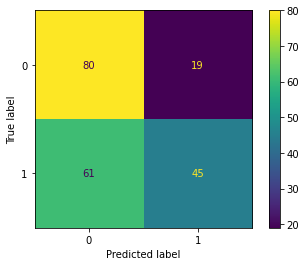

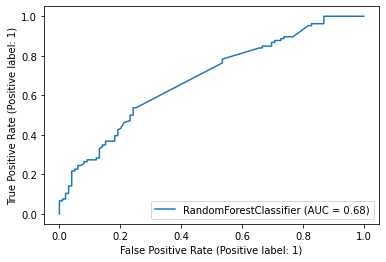

shape of words array = (820, 50)
shape of bigrams array = (820, 50)
<-------------- common words ------------------>
common words, row count: 820 


,crime,sadiq,khan,stabbing,police,hospital,mayor,yearold,life,stabbed,breaking,rushed,murder,injuries,death,...,charged,face,city,today,horror,silvertown,years,attack,london,violence,increase,reduce,week,accused,south
0,0.0,0.000000,0.000000,0.341125,0.371782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.526074,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.551685,0.551685,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.465487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<-------------- common bigrams ------------------>
common bigrams, row count: 820 


,sadiq khan,walthamforest breaking,breaking yearold,yearold rushed,rushed eastlondon,eastlondon hospital,hospital life,life threatening,threatening injuries,mayor sadiq,knife crime,evening standard,transit tfl,carnage increase,stabbed death,...,death near,khan urges,criminal offence,stabbing police,rushed hospital,speakers corner,brixton stabbing,near south,south underground,change isolation,isolation rules,rules early,murder probe,hate crime,fighting life
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<------- features created from WORDS only ---------->
shape of df_all_data = (820, 52)

 <----- First 2 rows of df_all_data ----->


,crime,sadiq,khan,stabbing,police,hospital,mayor,yearold,life,stabbed,breaking,rushed,murder,injuries,death,...,city,today,horror,silvertown,years,attack,london,violence,increase,reduce,week,accused,south,target,Tweet_lemmatized
0,0.0,0.000000,0.000000,0.341125,0.371782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,"['seriously', 'injured', 'stabbing', 'teen', '..."
1,0.0,0.551685,0.551685,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.465487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,"['’', 'six', 'years', '’', 'sadiq', 'khan', 'l..."


shape of labels = (820,)
shape of features = (820, 50)
Training Features Shape: (615, 50)
Training Labels Shape: (615,)
Testing Features Shape: (205, 50)
Testing Labels Shape: (205,)

------------------ parameters used -------------------

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': True, 'random_state': 42, 'verbose': 0, 'warm_start': False}


------------------------------------------------------------------
Printing performance metrics for normal
------------------------------------------------------------------

prediction accuracy 0.6146341463414634
precision 0.6956521739130435
recall 0.4528301886792453
Area under the curve score 0.6203544882790166




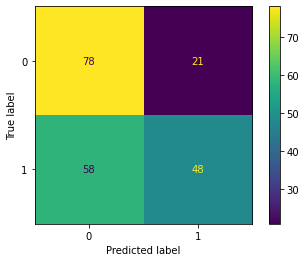

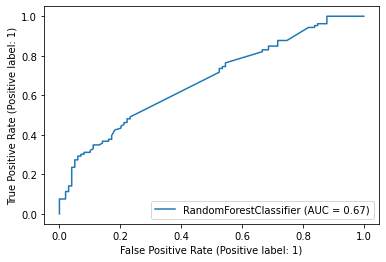

shape of words array = (820, 50)
shape of bigrams array = (820, 50)
<-------------- common words ------------------>
common words, row count: 820 


,crime,sadiq,khan,stabbing,police,hospital,mayor,yearold,life,stabbed,breaking,rushed,murder,injuries,death,...,charged,face,city,today,horror,silvertown,years,attack,london,violence,increase,reduce,week,accused,south
0,0.0,0.000000,0.000000,0.341125,0.371782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.526074,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.551685,0.551685,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.465487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<-------------- common bigrams ------------------>
common bigrams, row count: 820 


,sadiq khan,walthamforest breaking,breaking yearold,yearold rushed,rushed eastlondon,eastlondon hospital,hospital life,life threatening,threatening injuries,mayor sadiq,knife crime,evening standard,transit tfl,carnage increase,stabbed death,...,death near,khan urges,criminal offence,stabbing police,rushed hospital,speakers corner,brixton stabbing,near south,south underground,change isolation,isolation rules,rules early,murder probe,hate crime,fighting life
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<------- features created from BIGRAMS only ---------->
shape of df_all_data = (820, 52)

 <----- First 2 rows of df_all_data ----->


,sadiq khan,walthamforest breaking,breaking yearold,yearold rushed,rushed eastlondon,eastlondon hospital,hospital life,life threatening,threatening injuries,mayor sadiq,knife crime,evening standard,transit tfl,carnage increase,stabbed death,...,criminal offence,stabbing police,rushed hospital,speakers corner,brixton stabbing,near south,south underground,change isolation,isolation rules,rules early,murder probe,hate crime,fighting life,target,Tweet_lemmatized
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,"['seriously', 'injured', 'stabbing', 'teen', '..."
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,"['’', 'six', 'years', '’', 'sadiq', 'khan', 'l..."


shape of labels = (820,)
shape of features = (820, 50)
Training Features Shape: (615, 50)
Training Labels Shape: (615,)
Testing Features Shape: (205, 50)
Testing Labels Shape: (205,)

------------------ parameters used -------------------

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': True, 'random_state': 42, 'verbose': 0, 'warm_start': False}


------------------------------------------------------------------
Printing performance metrics for normal
------------------------------------------------------------------

prediction accuracy 0.5658536585365853
precision 0.5521472392638037
recall 0.8490566037735849
Area under the curve score 0.5558414331999239




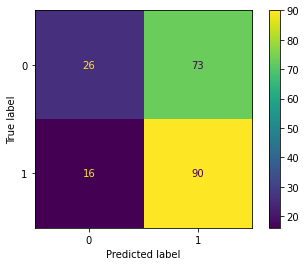

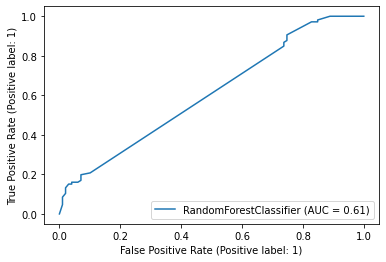

shape of words array = (820, 100)
shape of bigrams array = (820, 100)
<-------------- common words ------------------>
common words, row count: 820 


,crime,sadiq,khan,stabbing,police,hospital,mayor,yearold,life,stabbed,breaking,rushed,murder,injuries,death,...,year,wood,sherlockholmes,stop,fatal,know,fighting,great,bus,driver,broad,tube,home,urges,rules
0,0.0,0.000000,0.000000,0.341125,0.371782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.551685,0.551685,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<-------------- common bigrams ------------------>
common bigrams, row count: 820 


,sadiq khan,walthamforest breaking,breaking yearold,yearold rushed,rushed eastlondon,eastlondon hospital,hospital life,life threatening,threatening injuries,mayor sadiq,knife crime,evening standard,transit tfl,carnage increase,stabbed death,...,mask tube,offence says,boys arrested,police appeal,keen crime,crime fiction,fiction join,join digital,digital marketing,marketing publicity,publicity executive,bookboost iartg,watson author,charlie hebdo,hyde park
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<------- features created from both WORDS and BIGRAMS ------>
shape of df_all_data = (820, 202)

 <----- First 2 rows of df_all_data ----->


,sadiq khan,walthamforest breaking,breaking yearold,yearold rushed,rushed eastlondon,eastlondon hospital,hospital life,life threatening,threatening injuries,mayor sadiq,knife crime,evening standard,transit tfl,carnage increase,stabbed death,...,year,wood,sherlockholmes,stop,fatal,know,fighting,great,bus,driver,broad,tube,home,urges,rules
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


shape of labels = (820,)
shape of features = (820, 200)
Training Features Shape: (615, 200)
Training Labels Shape: (615,)
Testing Features Shape: (205, 200)
Testing Labels Shape: (205,)

------------------ parameters used -------------------

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': True, 'random_state': 42, 'verbose': 0, 'warm_start': False}


------------------------------------------------------------------
Printing performance metrics for normal
------------------------------------------------------------------

prediction accuracy 0.6878048780487804
precision 0.7282608695652174
recall 0.6320754716981132
Area under the curve score 0.6897751095864303




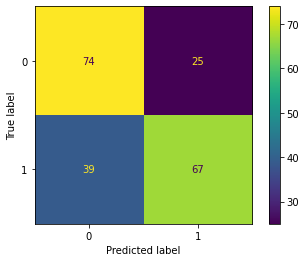

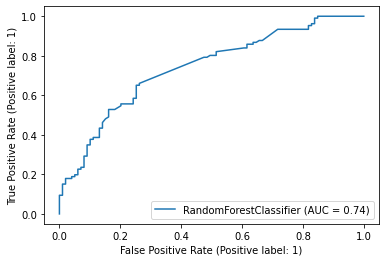

shape of words array = (820, 100)
shape of bigrams array = (820, 100)
<-------------- common words ------------------>
common words, row count: 820 


,crime,sadiq,khan,stabbing,police,hospital,mayor,yearold,life,stabbed,breaking,rushed,murder,injuries,death,...,year,wood,sherlockholmes,stop,fatal,know,fighting,great,bus,driver,broad,tube,home,urges,rules
0,0.0,0.000000,0.000000,0.341125,0.371782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.551685,0.551685,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<-------------- common bigrams ------------------>
common bigrams, row count: 820 


,sadiq khan,walthamforest breaking,breaking yearold,yearold rushed,rushed eastlondon,eastlondon hospital,hospital life,life threatening,threatening injuries,mayor sadiq,knife crime,evening standard,transit tfl,carnage increase,stabbed death,...,mask tube,offence says,boys arrested,police appeal,keen crime,crime fiction,fiction join,join digital,digital marketing,marketing publicity,publicity executive,bookboost iartg,watson author,charlie hebdo,hyde park
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<------- features created from WORDS only ---------->
shape of df_all_data = (820, 102)

 <----- First 2 rows of df_all_data ----->


,crime,sadiq,khan,stabbing,police,hospital,mayor,yearold,life,stabbed,breaking,rushed,murder,injuries,death,...,sherlockholmes,stop,fatal,know,fighting,great,bus,driver,broad,tube,home,urges,rules,target,Tweet_lemmatized
0,0.0,0.000000,0.000000,0.341125,0.371782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,"['seriously', 'injured', 'stabbing', 'teen', '..."
1,0.0,0.551685,0.551685,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,"['’', 'six', 'years', '’', 'sadiq', 'khan', 'l..."


shape of labels = (820,)
shape of features = (820, 100)
Training Features Shape: (615, 100)
Training Labels Shape: (615,)
Testing Features Shape: (205, 100)
Testing Labels Shape: (205,)

------------------ parameters used -------------------

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': True, 'random_state': 42, 'verbose': 0, 'warm_start': False}


------------------------------------------------------------------
Printing performance metrics for normal
------------------------------------------------------------------

prediction accuracy 0.6585365853658537
precision 0.7195121951219512
recall 0.5566037735849056
Area under the curve score 0.6621402706308368




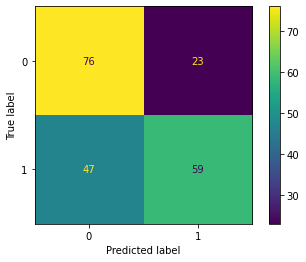

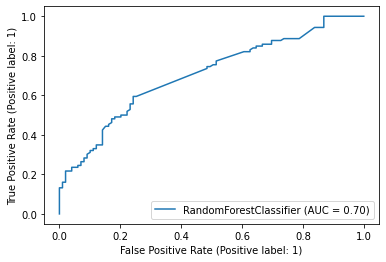

shape of words array = (820, 100)
shape of bigrams array = (820, 100)
<-------------- common words ------------------>
common words, row count: 820 


,crime,sadiq,khan,stabbing,police,hospital,mayor,yearold,life,stabbed,breaking,rushed,murder,injuries,death,...,year,wood,sherlockholmes,stop,fatal,know,fighting,great,bus,driver,broad,tube,home,urges,rules
0,0.0,0.000000,0.000000,0.341125,0.371782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.551685,0.551685,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<-------------- common bigrams ------------------>
common bigrams, row count: 820 


,sadiq khan,walthamforest breaking,breaking yearold,yearold rushed,rushed eastlondon,eastlondon hospital,hospital life,life threatening,threatening injuries,mayor sadiq,knife crime,evening standard,transit tfl,carnage increase,stabbed death,...,mask tube,offence says,boys arrested,police appeal,keen crime,crime fiction,fiction join,join digital,digital marketing,marketing publicity,publicity executive,bookboost iartg,watson author,charlie hebdo,hyde park
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<------- features created from BIGRAMS only ---------->
shape of df_all_data = (820, 102)

 <----- First 2 rows of df_all_data ----->


,sadiq khan,walthamforest breaking,breaking yearold,yearold rushed,rushed eastlondon,eastlondon hospital,hospital life,life threatening,threatening injuries,mayor sadiq,knife crime,evening standard,transit tfl,carnage increase,stabbed death,...,boys arrested,police appeal,keen crime,crime fiction,fiction join,join digital,digital marketing,marketing publicity,publicity executive,bookboost iartg,watson author,charlie hebdo,hyde park,target,Tweet_lemmatized
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,"['seriously', 'injured', 'stabbing', 'teen', '..."
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,"['’', 'six', 'years', '’', 'sadiq', 'khan', 'l..."


shape of labels = (820,)
shape of features = (820, 100)
Training Features Shape: (615, 100)
Training Labels Shape: (615,)
Testing Features Shape: (205, 100)
Testing Labels Shape: (205,)

------------------ parameters used -------------------

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': True, 'random_state': 42, 'verbose': 0, 'warm_start': False}


------------------------------------------------------------------
Printing performance metrics for normal
------------------------------------------------------------------

prediction accuracy 0.5853658536585366
precision 0.567741935483871
recall 0.8301886792452831
Area under the curve score 0.5767105012388032




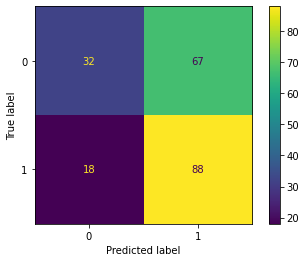

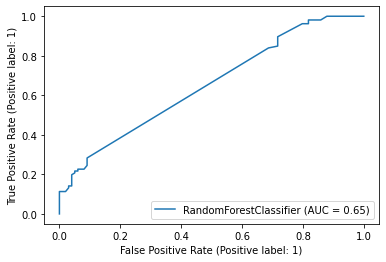

In [19]:
n=50 # number of words, bigrams to include in vocabularies
myMode = features_mode.DEFAULT # 'DEFAULT WORDS BIGRAMS'
description = 'Features: Words and Bigrams, Vocab Count: 50'
rf_result_row, rf, df_all_data = run_scenario(description, pruned_tweets, corpus, n, myMode, printFile='Y')
rf_results_df = rf_results_df.append(rf_result_row, ignore_index=True)

myMode = features_mode.WORDS # 'DEFAULT WORDS BIGRAMS'
description = 'Features: Words only, Vocab Count: 50'
rf_result_row, rf, df_all_data = run_scenario(description, pruned_tweets, corpus, n, myMode, printFile='N')
rf_results_df = rf_results_df.append(rf_result_row, ignore_index=True)

myMode = features_mode.BIGRAMS # 'DEFAULT WORDS BIGRAMS'
description = 'Features: Bigrams only, Vocab Count: 50'
rf_result_row, rf, df_all_data = run_scenario(description, pruned_tweets, corpus, n, myMode, printFile='N')
rf_results_df = rf_results_df.append(rf_result_row, ignore_index=True)

n=100 # number of words, bigrams to include in vocabularies
myMode = features_mode.DEFAULT # 'DEFAULT WORDS BIGRAMS'
description = 'Features: Words and Bigrams, Vocab Count: 100'
rf_result_row, rf, df_all_data = run_scenario(description, pruned_tweets, corpus, n, myMode, printFile='N')
rf_results_df = rf_results_df.append(rf_result_row, ignore_index=True)

myMode = features_mode.WORDS # 'DEFAULT WORDS BIGRAMS'
description = 'Features: Words only, Vocab Count: 100'
rf_result_row, rf, df_all_data = run_scenario(description, pruned_tweets, corpus, n, myMode, printFile='N')
rf_results_df = rf_results_df.append(rf_result_row, ignore_index=True)

myMode = features_mode.BIGRAMS # 'DEFAULT WORDS BIGRAMS'
description = 'Features: Bigrams only, Vocab Count: 100'
rf_result_row, rf, df_all_data = run_scenario(description, pruned_tweets, corpus, n, myMode, printFile='N')
rf_results_df = rf_results_df.append(rf_result_row, ignore_index=True)

In [20]:
rf_results_df.sort_values(by='auc', ascending=False)

,description,accuracy,precision,recall,auc,true positive,false positive,true negative,false negative
3,"Features: Words and Bigrams, Vocab Count: 100",0.687805,0.728261,0.632075,0.689775,67,25,74,39
4,"Features: Words only, Vocab Count: 100",0.658537,0.719512,0.556604,0.662140,59,23,76,47
1,"Features: Words only, Vocab Count: 50",0.614634,0.695652,0.452830,0.620354,48,21,78,58
0,"Features: Words and Bigrams, Vocab Count: 50",0.609756,0.703125,0.424528,0.616305,45,19,80,61
5,"Features: Bigrams only, Vocab Count: 100",0.585366,0.567742,0.830189,0.576711,88,67,32,18
2,"Features: Bigrams only, Vocab Count: 50",0.565854,0.552147,0.849057,0.555841,90,73,26,16


### 2.4 Assess results 
Best results were generated using both words and bigrams and also when using the top 100 (rather than 50) words/bigrams in their respective vocabularies. However, it should be noted that the best configuration is heavily influenced by the tweets used to pad the FOR camp and these are selected at random. This means we sometimes get better results with the top 50 rather than top 100 words and bigrams. It should also be noted that the choice of padding tweets can also affect the overall performance of the model. Such volatility in a model is clearly undesirable and this is a direct consequence of having so few FOR tweets.

In terms of the current results, recall performance is better than we expected given we had such a small dataset. However, this is somewhat at the expense of precision but precision is particularly sensitive to the tweets we used to pad the FOR case. For comparison, Bovet results were as follows:
- BOVET
    - AUC: 0.89
    - Accuracy: 0.81
    - Precision 0.81
    - Recall: 0.81

### 2.5 Feature Importance
We now visualising top 20 most important features in our best module permutation.

shape of words array = (820, 100)
shape of bigrams array = (820, 100)
<-------------- common words ------------------>
common words, row count: 820 


,crime,sadiq,khan,stabbing,police,hospital,mayor,yearold,life,stabbed,breaking,rushed,murder,injuries,death,...,year,wood,sherlockholmes,stop,fatal,know,fighting,great,bus,driver,broad,tube,home,urges,rules
0,0.0,0.000000,0.000000,0.341125,0.371782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.551685,0.551685,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<-------------- common bigrams ------------------>
common bigrams, row count: 820 


,sadiq khan,walthamforest breaking,breaking yearold,yearold rushed,rushed eastlondon,eastlondon hospital,hospital life,life threatening,threatening injuries,mayor sadiq,knife crime,evening standard,transit tfl,carnage increase,stabbed death,...,mask tube,offence says,boys arrested,police appeal,keen crime,crime fiction,fiction join,join digital,digital marketing,marketing publicity,publicity executive,bookboost iartg,watson author,charlie hebdo,hyde park
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<------- features created from both WORDS and BIGRAMS ------>
shape of df_all_data = (820, 202)

 <----- First 2 rows of df_all_data ----->


,sadiq khan,walthamforest breaking,breaking yearold,yearold rushed,rushed eastlondon,eastlondon hospital,hospital life,life threatening,threatening injuries,mayor sadiq,knife crime,evening standard,transit tfl,carnage increase,stabbed death,...,year,wood,sherlockholmes,stop,fatal,know,fighting,great,bus,driver,broad,tube,home,urges,rules
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


shape of labels = (820,)
shape of features = (820, 200)
Training Features Shape: (615, 200)
Training Labels Shape: (615,)
Testing Features Shape: (205, 200)
Testing Labels Shape: (205,)

------------------ parameters used -------------------

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': True, 'random_state': 42, 'verbose': 0, 'warm_start': False}


------------------------------------------------------------------
Printing performance metrics for normal
------------------------------------------------------------------

prediction accuracy 0.6878048780487804
precision 0.7282608695652174
recall 0.6320754716981132
Area under the curve score 0.6897751095864303




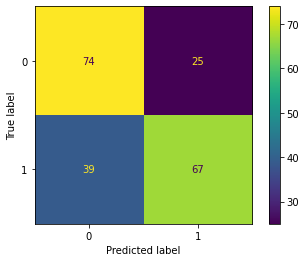

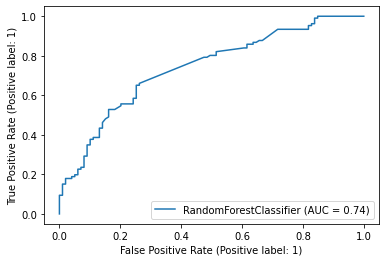

{'description': 'Features: Words and Bigrams, Vocab Count: 100',
 'accuracy': 0.6878048780487804,
 'precision': 0.7282608695652174,
 'recall': 0.6320754716981132,
 'auc': 0.6897751095864303,
 'true positive': 67,
 'false positive': 25,
 'true negative': 74,
 'false negative': 39}

In [21]:
n=100 # number of words, bigrams to include in vocabularies
myMode = features_mode.DEFAULT # 'DEFAULT WORDS BIGRAMS'
description = 'Features: Words and Bigrams, Vocab Count: 100'
rf_result_row, rf, df_all_data = run_scenario(description, pruned_tweets, corpus, n, myMode, printFile='Y')

rf_result_row

In [22]:
# Calculate feature importances
importances = rf.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
    
feature_list = list(df_all_data.columns)
    
# Rearrange feature names so they match the sorted feature importances
names = [feature_list[i] for i in indices]
    
# select top 20 
n_features = 25
top_names = names[:n_features]
top_n_indices = indices[:n_features]
top_importances = importances[top_n_indices]

feature_importance_df = pd.DataFrame(list(zip(top_names, top_importances)),
               columns =['word_or_bigram', 'importance_value'])



In [23]:
import altair as alt

bar = alt.Chart(feature_importance_df, title='Feature Importance').mark_bar(
    opacity=0.6, color='firebrick', size=20).encode(
    y=alt.Y('word_or_bigram:N', axis=alt.Axis(title=None, ticks=False), sort='-x'),
    x=alt.X('importance_value:Q', axis=None),  
)

text = alt.Chart(feature_importance_df).mark_text(
    align='center',
    baseline='middle',
    color='white',
    dx=-20 
).encode(
    y=alt.Y('word_or_bigram:N', axis=alt.Axis(ticks=False), sort='-x'),
    x=alt.X('importance_value:Q', axis=None),
    text=alt.Text('importance_value:Q', format=',.2')
)

(bar + text).properties(
    width=400,
    height=550).configure_axis(
    grid=False,
    domain=False
).configure_view(
    strokeWidth=0)

alt.LayerChart(...)

#### 2.5.1 Check how many tweets contain each important word and see what label they have
- We load 'twitter_features.csv' as this contains all the features, along with lemmatized tokens and the associated label
- for each of the most important words, find out how many for and against tweets contain those words as a proportion of all for and against tweets

In [24]:
tweets_and_features = pd.read_csv('./DataSources/TwitterData/twitter_features.csv')

print(tweets_and_features.shape)
display(tweets_and_features.head(2))

all_tweets_count = tweets_and_features.target.count()
for_tweets_count = tweets_and_features['target'][tweets_and_features.target==0].count()
against_tweets_count = tweets_and_features['target'][tweets_and_features.target==1].count()

print("total number of tweets: {}, number with label = FOR: {}, number with label = AGAINST: {}".format(all_tweets_count,
                                                                                                       for_tweets_count,
                                                                                                       against_tweets_count))



(820, 202)


,sadiq khan,walthamforest breaking,breaking yearold,yearold rushed,rushed eastlondon,eastlondon hospital,hospital life,life threatening,threatening injuries,mayor sadiq,knife crime,evening standard,transit tfl,carnage increase,stabbed death,...,year,wood,sherlockholmes,stop,fatal,know,fighting,great,bus,driver,broad,tube,home,urges,rules
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


total number of tweets: 820, number with label = FOR: 410, number with label = AGAINST: 410


In [27]:
def get_stats(tweets_and_features, word, for_tweets_count, against_tweets_count):
    for_count = tweets_and_features[word][(tweets_and_features[word] > 0) & 
                                          (tweets_and_features.target==0)].count()
    
    for_pct = for_count / for_tweets_count
    
    against_count = tweets_and_features[word][(tweets_and_features[word] > 0) & 
                                          (tweets_and_features.target==1)].count()
    
    against_pct = against_count / against_tweets_count
    
    delta = np.abs(against_count - for_count) / (against_count + for_count)
    
    stats_row = {'word': word,
            'delta' : delta,
            'for_count': for_count,
            'against_count': against_count,
            'for_pct': for_pct,
            'against_pct': against_pct}
    
    return stats_row

words = ['crime', 'sadiq', 'khan', 'stabbing', 'police', 'news', 'live', 'murder', 'sadiq khan', 'stabbed', 'death']
stats_df = pd.DataFrame(columns=['word', 'delta', 'for_count', 'against_count', 'for_pct', 'against_pct'])

for word in words:
    stats_row = get_stats(tweets_and_features, word, for_tweets_count, against_tweets_count)
    stats_df = stats_df.append(stats_row, ignore_index=True)
    
stats_df.sort_values('delta',ascending=False)

,word,delta,for_count,against_count,for_pct,against_pct
9,stabbed,0.550000,9,31,0.021951,0.075610
7,murder,0.529412,8,26,0.019512,0.063415
3,stabbing,0.422680,28,69,0.068293,0.168293
10,death,0.393939,10,23,0.024390,0.056098
8,sadiq khan,0.321429,74,38,0.180488,0.092683
1,sadiq,0.317073,81,42,0.197561,0.102439
4,police,0.287671,26,47,0.063415,0.114634
2,khan,0.284553,79,44,0.192683,0.107317
5,news,0.200000,12,8,0.029268,0.019512
0,crime,0.134752,80,61,0.195122,0.148780


#### Comments
Looking at both the feature importance and also the number of tweets containing these important words or phrases we can see the follow words are the most important in our classifier:
- crime, sadiq, khan, police, stabbing, stabbed, sadiq khan and mayor.

The statistics also give us some confidence that these words influence tweets being either FOR (actually NOT AGAINST is more accurate) or AGAINST and so the final step is to create a new pruned dataset with just the important features and then retrain our classifier. However first we want to double check that the important features have been correctly excluded from the message text. To do this we will check to see any hashtags in a tweets which has the following words present in the text (many of the important features aren't included in our labelling hashtags):
- crime
- sadiqkhan
- stabbing

In [29]:
def check_for_text_and_hashtags(tweets, word):
    print("\n<---------------------------- processing {} ---------------------------->\n".format(word))
    clean_shape = tweets[['hashtags', 'Clean_MessageText', 'Clean_MessageText_refined']][tweets.Clean_MessageText.str.contains(word)].shape
    refined_clean = tweets[['hashtags', 'Clean_MessageText', 'Clean_MessageText_refined']][tweets.Clean_MessageText_refined.str.contains(word)]

    refined_clean_shape = refined_clean.shape
    print("Number of tweets containing {} in Clean_MessageText is {} and in Clean_MessageText_refined is {}".format(word,
                                                                                                                   clean_shape[0],
                                                                                                                   refined_clean_shape[0]))
    
    # now we want tweets that contain the word AND also have the word in their hashtags
    
    tweet_count = 0
    for index, tweet in refined_clean.iterrows():
        my_hashtags = string_to_list_hash(tweet['hashtags'])
        my_hashtags_as_set = set(my_hashtags)
        
        intersection = my_hashtags_as_set.intersection(word)
        
        if len(intersection) > 0:
            print(tweets.hashtags)
        else:
            tweet_count = tweet_count + 1
            
    print("Number of tweets with clean message text which do not contain a hashtag used to label: {}".format(tweet_count))
    
word_list = ['crime', 'sadiqkhan', 'stabbing']

print("Shape of original dataframe: {}".format(pruned_tweets.shape))
          
for word in word_list:
    check_for_text_and_hashtags(pruned_tweets, word)


Shape of original dataframe: (820, 7)

<---------------------------- processing crime ---------------------------->

Number of tweets containing crime in Clean_MessageText is 268 and in Clean_MessageText_refined is 160
Number of tweets with clean message text which do not contain a hashtag used to label: 160

<---------------------------- processing sadiqkhan ---------------------------->

Number of tweets containing sadiqkhan in Clean_MessageText is 20 and in Clean_MessageText_refined is 3
Number of tweets with clean message text which do not contain a hashtag used to label: 3

<---------------------------- processing stabbing ---------------------------->

Number of tweets containing stabbing in Clean_MessageText is 138 and in Clean_MessageText_refined is 103
Number of tweets with clean message text which do not contain a hashtag used to label: 103


#### Comments 
We can see from pruned_tweets.head() that labelling hashtags are removed from Clean_MessageText_refined and we can also see that our double check confirms we don't have any tweets where Clean_MessageText_refined contains a word used in a labelling hashtag AND having that hashtag in its list of hashtags.

We test this seperately in Appendix B and we confirm we are satisfied this logic is working as expected.

### 2.6. Rerun model withonly the most important features

shape of words array = (820, 10)
shape of bigrams array = (820, 1)
<------- features created from both WORDS and BIGRAMS ------>
shape of df_all_data = (820, 13)

 <----- First 2 rows of df_all_data ----->


,sadiq khan,target,Tweet_lemmatized,crime,sadiq,khan,stabbing,police,news,live,murder,stabbed,death
0,0.0,1,"['seriously', 'injured', 'stabbing', 'teen', '...",0.0,0.000000,0.000000,0.676074,0.736834,0.0,0.0,0.0,0.0,0.0
1,1.0,1,"['’', 'six', 'years', '’', 'sadiq', 'khan', 'l...",0.0,0.707107,0.707107,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


shape of labels = (820,)
shape of features = (820, 11)
Training Features Shape: (615, 11)
Training Labels Shape: (615,)
Testing Features Shape: (205, 11)
Testing Labels Shape: (205,)

------------------ parameters used -------------------

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': True, 'random_state': 42, 'verbose': 0, 'warm_start': False}


------------------------------------------------------------------
Printing performance metrics for normal
------------------------------------------------------------------

prediction accuracy 0.5853658536585366
precision 0.7058823529411765
recall 0.33962264150943394
Area under the curve score 0.5940537449971413




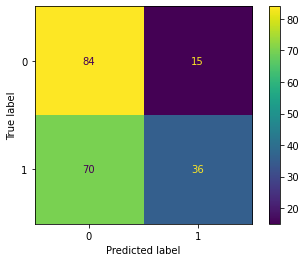

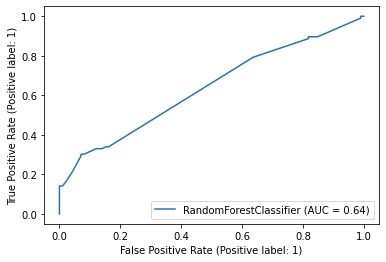

In [33]:
words_vocab = ['crime', 'sadiq', 'khan', 'stabbing', 'police', 'news', 'live', 'murder', 'stabbed', 'death']
ngrams_vocab = ['sadiq khan']

df_individual_words = get_word_features(words_vocab, corpus)
df_ngrams = get_bigram_features(ngrams_vocab, corpus)

features, labels, df_all_data = get_features_and_labels(pruned_tweets, df_individual_words, df_ngrams, 
                                           myMode, printFile='N')
    
accuracy, precision, recall, roc_auc, tn, fp, fn, tp, rf = train_and_test_classifier(features, labels)

#### Comments
Pruning the features so significantly degrades performance significantly and this is understandable because we use so few words as features and so far more tweets won't contain these features and hence the recall performance deteriorates. For this reason we will carry on using the optimal feature configuration identified previously.

### 2.7. Choose optimal hyperparameters
    
#### 2.7.1 First recreate features using best feature configuration

In [35]:
n=100 # number of words, bigrams to include in vocabularies
myMode = features_mode.DEFAULT # 'DEFAULT WORDS BIGRAMS'

words_vocab, ngrams_vocab = get_words_ngrams(pruned_tweets.Clean_MessageText_refined, n)
df_individual_words = get_word_features(words_vocab, corpus)
df_ngrams = get_bigram_features(ngrams_vocab, corpus)

features, labels, df_all_data = get_features_and_labels(pruned_tweets, df_individual_words, df_ngrams, 
                                           myMode, printFile='N')

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

train_features.shape, test_features.shape

shape of words array = (820, 100)
shape of bigrams array = (820, 100)
<------- features created from both WORDS and BIGRAMS ------>
shape of df_all_data = (820, 202)

 <----- First 2 rows of df_all_data ----->


,sadiq khan,walthamforest breaking,breaking yearold,yearold rushed,rushed eastlondon,eastlondon hospital,hospital life,life threatening,threatening injuries,mayor sadiq,knife crime,evening standard,transit tfl,carnage increase,stabbed death,...,year,wood,sherlockholmes,stop,fatal,know,fighting,great,bus,driver,broad,tube,home,urges,rules
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


shape of labels = (820,)
shape of features = (820, 200)


((615, 200), (205, 200))

#### 2.7.2 Perform grid search
- We include the hyperparameters used as defaults previously within the hyperparameter grid values as these provide a reasonable starting point
    - {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': True, 'random_state': 42, 'verbose': 0, 'warm_start': False}

In [36]:
import time
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'oob_score' : [True],
    'max_depth': [5, 10, 20, 30],
    'max_features': [100, 200],
    'min_samples_leaf': [1, 5, 10, 20, 30],
    'min_samples_split': [2, 10, 20, 30],
    'n_estimators': [250, 500, 1000]
}

# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
gs_rf = GridSearchCV(estimator = rf, param_grid = param_grid, refit=True,
                          cv = 3, n_jobs = -1, verbose = 2)

tic = time.perf_counter()
gs_rf.fit(train_features, train_labels)
toc = time.perf_counter()

print(f"Running the Random Forest classifer on our best features dataset took {toc - tic:0.4f} seconds")

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [5, 10, 20, 30],
                         'max_features': [100, 200],
                         'min_samples_leaf': [1, 5, 10, 20, 30],
                         'min_samples_split': [2, 10, 20, 30],
                         'n_estimators': [250, 500, 1000],
                         'oob_score': [True]},
             verbose=2)

Running the Random Forest classifer on our best features dataset took 396.0381 seconds


------------------------------------------------------------------
Printing performance metrics for optimal model
------------------------------------------------------------------

prediction accuracy 0.6780487804878049
precision 0.7272727272727273
recall 0.6037735849056604
Area under the curve score 0.680674671240709




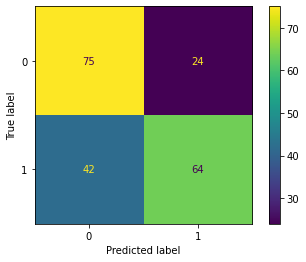

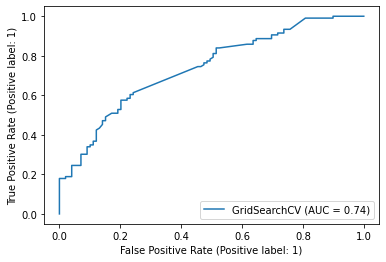

In [37]:
y_pred = gs_rf.predict(test_features)

accuracy, precision, recall, roc_auc, tn, fp, fn, tp = ml_performance.RF_performance_reporting(gs_rf, 
                                                                                test_features, 
                                                                                test_labels, 
                                                                                y_pred, 
                                                                                'optimal model', 
                                                                                print_output=True)

In [38]:
print(gs_rf.best_score_, gs_rf.best_params_)

0.6731707317073171 {'bootstrap': True, 'max_depth': 30, 'max_features': 100, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250, 'oob_score': True}


#### Comments
The cross validated results ever so slightly worse than our original results, mainly due to a slightly lower recall performance but we choose this model because, having been cross validated, we can have more confidence that it will be more generalisable.

In [39]:
all_unique_users = all_tweets.tweeter_screen_name.nunique()
pruned_unique_users = pruned_tweets.tweeter_screen_name.nunique()

print("Percentage of all tweeters in our pruned dataset = {:.2%}".format(pruned_unique_users / all_unique_users))

Percentage of all tweeters in our pruned dataset = 6.83%


### 2.8. Predict classes for remaining tweets

Create features for whole dataset
- We use vocabs from the pruned dataset but the corpus is based on the bigger dataset 
- the bigger dataset will comprise tweets which have a label = 'NONE' and so we won't be predicting using any data used previously to train our model
- we will then join the results of these predicted labels with tweets from the original dataset that had labels = 'FOR' or 'AGAINST'
    - this does mean we lose tweets which had hashtags that weren't used to label our tweets but this a small number of tweets and so doesn't have a material effect
    
#### 2.8.1 Get unseen tweets

In [40]:
all_tweets_original['label'] = '' 
all_tweets_original['label'] = all_tweets_original['hashtags'].apply(lambda x: get_tweet_class(x, set_for, set_against))

print("shape for original tweets: {}".format(all_tweets_original.shape))

all_tweets_new = all_tweets_original[~all_tweets_original['Clean_MessageText'].isnull()]
all_tweets_new = all_tweets_new[all_tweets_new['Clean_MessageText'].str.len() > 4]
print("shape for original tweets where bad message text removed: {}".format(all_tweets_new.shape))

remaining_tweets = all_tweets_new[all_tweets_new.label=='NONE'].copy().reset_index(drop=True)

remaining_tweets['Clean_MessageText_refined'] = remaining_tweets.apply(lambda x: remove_label_hashtags(x['Clean_MessageText'], 
                                                                                                x['hashtags'], ignore_words), 
                                                                                                 axis=1)

print("labels in remaining tweets {}".format(remaining_tweets.label.unique()))
print("shape for remaining tweets where containing purely tweets without hashtags: {}".format(remaining_tweets.shape))

remaining_tweets.head()

shape for original tweets: (41706, 27)
shape for original tweets where bad message text removed: (41472, 27)
labels in remaining tweets ['NONE']
shape for remaining tweets where containing purely tweets without hashtags: (39353, 28)


,index,tweet_id,tweet_date,tweeter_id,tweeter_user_name,tweeter_screen_name,tweeter_location,message_text,in_reply_to_user_screen_name,quote_tweet_screen_name,favourite_count,retweet_count,is_retweet,extract_run_date,retrieved_using_search_term,retweeted,mentioned,hashtags,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_lemmatized,Clean_MessageText,tweet_date_dt,time_bins_12h,day_bins,label,Clean_MessageText_refined
0,0,1420355029081395203,2021-07-28 12:06:42,865262041103302656,Chris Myers,myerschrismyer1,Richmond North Yorkshire,RT @LeslieH24367191: 'Do better!' Boris Johnso...,NaN,NaN,0,40,Y,20210728,London AND knife AND crime,['@LeslieH24367191'],[],[],Do better Boris Johnson issues scathing respo...,"['do', 'better', 'boris', 'johnson', 'issues',...","['better', 'boris', 'johnson', 'issues', 'scat...","['good', 'boris', 'johnson', 'issues', 'scathi...",good boris johnson issues scathing response sa...,2021-07-28 12:06:42,2021-07-28 12:00:00,2021-07-28 00:00:00,NONE,good boris johnson issues scathing response sa...
1,1,1420354120041615364,2021-07-28 12:03:05,229645453,Emily Sheffield,emilysheffield,London,RT @NaheedMajeed: Spot on @standardnews With L...,NaN,NaN,0,2,Y,20210728,London AND knife AND crime,['@NaheedMajeed'],['@standardnews'],[],Spot on With London on track to break record...,"['spot', 'on', 'with', 'london', 'on', 'track'...","['spot', 'track', 'break', 'record', 'teenage'...","['spot', 'track', 'break', 'record', 'teenage'...",spot track break record teenage murdersstop se...,2021-07-28 12:03:05,2021-07-28 12:00:00,2021-07-28 00:00:00,NONE,spot track break record teenage murdersstop se...
2,2,1420351785156366337,2021-07-28 11:53:49,2843896642,Basilewitch,basilewitch,France,RT @Short2Cjs: Boris today speaking to Nick Fe...,NaN,NaN,0,4,Y,20210728,London AND knife AND crime,['@Short2Cjs'],[],[],Boris today speaking to Nick Ferrari about Kh...,"['boris', 'today', 'speaking', 'to', 'nick', '...","['boris', 'today', 'speaking', 'nick', 'ferrar...","['boris', 'today', 'speaking', 'nick', 'ferrar...",boris today speaking nick ferrari khan … done ...,2021-07-28 11:53:49,2021-07-28 00:00:00,2021-07-28 00:00:00,NONE,boris today speaking nick ferrari khan … done ...
3,3,1420350419449094148,2021-07-28 11:48:23,556315551,Dean Cowcher,DeanCowcher,Bexleyheath London England,RT @LeslieH24367191: 'Do better!' Boris Johnso...,NaN,NaN,0,40,Y,20210728,London AND knife AND crime,['@LeslieH24367191'],[],[],Do better Boris Johnson issues scathing respo...,"['do', 'better', 'boris', 'johnson', 'issues',...","['better', 'boris', 'johnson', 'issues', 'scat...","['good', 'boris', 'johnson', 'issues', 'scathi...",good boris johnson issues scathing response sa...,2021-07-28 11:48:23,2021-07-28 00:00:00,2021-07-28 00:00:00,NONE,good boris johnson issues scathing response sa...
4,4,1420349615954669574,2021-07-28 11:45:11,1267062754915090434,Alfiecat,sonya_annie,unknown,RT @Short2Cjs: Boris today speaking to Nick Fe...,NaN,NaN,0,4,Y,20210728,London AND knife AND crime,['@Short2Cjs'],[],[],Boris today speaking to Nick Ferrari about Kh...,"['boris', 'today', 'speaking', 'to', 'nick', '...","['boris', 'today', 'speaking', 'nick', 'ferrar...","['boris', 'today', 'speaking', 'nick', 'ferrar...",boris today speaking nick ferrari khan … done ...,2021-07-28 11:45:11,2021-07-28 00:00:00,2021-07-28 00:00:00,NONE,boris today speaking nick ferrari khan … done ...


#### 2.8.2 Generate features for unseen tweets
We use the new tweets to create our corpus but reuse words_vocab, ngrams_vocab created from the pruned tweets so that our feature categories are the same as used to train our model. 
- words_vocab, ngrams_vocab were created previously as input to our grid search

In [44]:
n=100

corpus_remaining = get_corpus(remaining_tweets)

df_individual_words = get_word_features(words_vocab, corpus_remaining)
df_ngrams = get_bigram_features(ngrams_vocab, corpus_remaining)

df_all_data = df_ngrams.join(df_individual_words)
features = np.array(df_all_data)

print("shape of features array: {}".format(features.shape))

The document corpus has length: 39353
<----------------- corpus -------------->


['good boris johnson issues scathing response sadiq khans record knife crime',
 'spot track break record teenage murdersstop search vital tool no…',
 'boris today speaking nick ferrari khan … done fight knife crime streets of…',
 'good boris johnson issues scathing response sadiq khans record knife crime',
 'boris today speaking nick ferrari khan … done fight knife crime streets of…']

['recognise officers want identify connection stabbing west india quay dlr station tu…',
 'breaking police rush scene horror stabbing knifed times broad daylight yet another st…',
 'breaking police rush scene horror stabbing knifed times broad daylight yet another st…',
 'recognise officers want identify connection stabbing west india quay dlr station tu…',
 'recognise officers want identify connection stabbing west india quay dlr station tu…']


<--------- original tweets ------------->
The tweet dataframe has length: 39353


0    good boris johnson issues scathing response sa...
1    spot track break record teenage murdersstop se...
2    boris today speaking nick ferrari khan … done ...
3    good boris johnson issues scathing response sa...
4    boris today speaking nick ferrari khan … done ...
Name: Clean_MessageText_refined, dtype: object

39348    recognise officers want identify connection st...
39349    breaking police rush scene horror stabbing kni...
39350    breaking police rush scene horror stabbing kni...
39351    recognise officers want identify connection st...
39352    recognise officers want identify connection st...
Name: Clean_MessageText_refined, dtype: object

shape of words array = (39353, 100)
shape of bigrams array = (39353, 100)
shape of features array: (39353, 200)


#### 2.8.3 Label unseen tweets
Use the previously created model to predict labels

In [45]:
predictions = gs_rf.predict(features)

In [49]:
df_predictions = pd.DataFrame(predictions, columns = ['predicted_label'])
predictions_shape = df_predictions.shape
print("shape of predictions array: {}".format(df_predictions.shape))

count_unseen = predictions_shape[0]
predictions_for = df_predictions['predicted_label'][df_predictions.predicted_label==0].count()
predictions_for_pct = predictions_for/count_unseen
predictions_against = df_predictions['predicted_label'][df_predictions.predicted_label==1].count()
predictions_against_pct = predictions_against/count_unseen

print("number of predictions = FOR: {:,} ({:.2%})".format(predictions_for, predictions_for_pct))
print("shape of predictions = AGAINST: {:,} ({:.2%})".format(predictions_against, predictions_against_pct))

shape of predictions array: (39353, 1)
number of predictions = FOR: 22,973 (58.38%)
shape of predictions = AGAINST: 16,380 (41.62%)


#### Comments
While we have labeled a number of tweets as being 'FOR' the mayor, the reality is that we had too few tweets to be able to realistically predict whether a tweet is actually for the mayor and instead what we are really predicting is that the tweet isn't vocally against the mayor. So what we therefore have is a body of tweets where we've identified about 40% being against the mayor. 

However, as we saw previously, we know that less than 20 tweets used hashtags that were explicitly pro Mayor versus around 400 using anti mayor hashtags.

### 2.9 Combine datasets and export
We now merge our predictions with the remaining tweet data and then convert the labels to FOR if predicted label was 0 and AGAINST if it was 1.
- We know from previously that the indexes of both tweets and predictions are the same and so we can just join the data

Then we concatenate our data with the pruned dataset to produce a single dataset of labeled tweets.

#### 2.9.1 Merge datasets

In [52]:
remaining_tweets_labeled = remaining_tweets.join(df_predictions)

remaining_tweets_labeled.loc[remaining_tweets_labeled.predicted_label == 0,'label'] = 'NOT_AGAINST'
remaining_tweets_labeled.loc[remaining_tweets_labeled.predicted_label == 1,'label'] = 'AGAINST'

remaining_tweets_labeled.drop('predicted_label', axis = 1, inplace=True)

In [53]:
for_against_tweets = all_tweets_new[all_tweets_new.label.isin(['AGAINST', 'FOR'])].copy().reset_index(drop=True)

frames = [for_against_tweets, remaining_tweets_labeled]

all_labeled_tweets = pd.concat(frames).reset_index(drop=True)

print("shape of all_labeled_tweets: {}".format(all_labeled_tweets.shape))

shape of all_labeled_tweets: (40206, 28)


#### 2.9.2 Sense check our data
- Look at shapes before and after
- Look at label counts of for, against, not_against

In [54]:
print("Number of rows in for_against dataframe: {}, remaining_tweets_labeled: {}, and combined: {}".format(for_against_tweets['label'].count(), 
                                                                                                           remaining_tweets_labeled['label'].count(), 
                                                                                                           all_labeled_tweets['label'].count()))

all_labeled_tweets_count = all_labeled_tweets['label'].count()
for_count_labeled = all_labeled_tweets['label'][all_labeled_tweets.label == 'FOR'].count()
for_pct_labeled = for_count_labeled / all_labeled_tweets_count
against_count_labeled = all_labeled_tweets['label'][all_labeled_tweets.label == 'AGAINST'].count()
against_pct_labeled = against_count_labeled / all_labeled_tweets_count
not_against_count_labeled = all_labeled_tweets['label'][all_labeled_tweets.label == 'NOT_AGAINST'].count()
not_against_pct_labeled = not_against_count_labeled / all_labeled_tweets_count

print("\nCount (and percent) of labels by category in combined dataframe all_labeled_tweets:")
print("'FOR': {:,}({:.2%}), \n'AGAINST': {:,}({:.2%}), \n'NOT AGAINST': {:,}({:.2%})".format(for_count_labeled, 
                                                                                 for_pct_labeled,
                                                                                 against_count_labeled, 
                                                                                 against_pct_labeled,
                                                                                 not_against_count_labeled,
                                                                                 not_against_pct_labeled))



Number of rows in for_against dataframe: 853, remaining_tweets_labeled: 39353, and combined: 40206

Count (and percent) of labels by category in combined dataframe all_labeled_tweets:
'FOR': 25(0.06%), 
'AGAINST': 17,208(42.80%), 
'NOT AGAINST': 22,973(57.14%)


#### Sense check comments

The combined dataset has the expected number of rows: all tweets minus tweets with hashtags not equal to FOR or AGAINST
The 'FOR' tweets are same as in original dataset
The 'AGAINST' tweets = tweets labelled AGAINST in original dataset plus tweets predicted as against
'NOT AGAINST' tweets comprise the balance

We therefore conclude the data has been correctly constructed

### 2.10 Reasonableness check - compare with hand labeling
We use hashtag cooccurrance as the basis for labelling our tweets prior to performing machine learning. Another common approach is to manually label them and this approach has been seen to produce better results than lexicon based sentiment analysis [1] but its main drawback is time taken to manually label the tweets. However, reviewing a subset of tweets we have specified as being AGAINST or NOT_AGAINST to see how we would have labeled them manually is a good sense check of the classification model's ability to produce reasonable predictions. This is what we will do now.
- We will randomly sample 100 tweets from remaining_tweets and export them to a csv file where we will manually annotate labels to them. We suffix the annotated file with '_annotated'
- We will then import the annotated file, join it to our labeled tweet file and review differences in labeling

Note: editing the file in excel reformats the id field and so we prefix it with a single quote to trick excel into treating the field like a string

#### <--- A different random sample is produced each time and so don't run this next cell unless you want a new sample and want to manually label the new rows --->

In [64]:
random_sample = remaining_tweets[['tweet_id', 'message_text']].sample(n=100).copy()
random_sample['tweet_id'] = random_sample['tweet_id'].astype(str)
random_sample['tweet_id'] = "'" + random_sample['tweet_id']

random_sample.to_csv('./DataSources/TwitterData/sampled_tweets.csv', index=False)

In [65]:
random_sample_annotated = pd.read_csv('./DataSources/TwitterData/sampled_tweets_annotated.csv')
random_sample_annotated['tweet_id'] = random_sample_annotated['tweet_id'].str[1:]
random_sample_annotated['tweet_id'] = random_sample_annotated['tweet_id'].astype(np.int64)

random_sample_annotated.head()

,tweet_id,message_text,annotated_label
0,1419959168119808001,RT @KoolKat1025: A woman getting stabbed in Lo...,AGAINST
1,1426815518103724034,@heather_venter @MailOnline Londonstahn anoth...,AGAINST
2,1421723811066548225,RT @KateBolger7: Are you for real? The air qua...,NOT_AGAINST
3,1428318497382223872,RT @tatjanasuarez: Just days after incel as a ...,NOT_AGAINST
4,1427755716077670407,@MayorofLondon No it isn’t. People need to lea...,NOT_AGAINST


####  2.10.1 Join annotated data with remaining_tweets_labeled

In [66]:
remaining_tweets_compare = remaining_tweets_labeled[['tweet_id', 'message_text', 'Clean_MessageText', 'label']].copy()

df_merged = pd.merge(random_sample_annotated, remaining_tweets_compare, left_on='tweet_id', right_on='tweet_id')

df_merged.head()

,tweet_id,message_text_x,annotated_label,message_text_y,Clean_MessageText,label
0,1419959168119808001,RT @KoolKat1025: A woman getting stabbed in Lo...,AGAINST,RT @KoolKat1025: A woman getting stabbed in Lo...,woman getting stabbed yesterday headline news ...,AGAINST
1,1426815518103724034,@heather_venter @MailOnline Londonstahn anoth...,AGAINST,@heather_venter @MailOnline Londonstahn anoth...,londonstahn another another drive sadiq khan p...,NOT_AGAINST
2,1421723811066548225,RT @KateBolger7: Are you for real? The air qua...,NOT_AGAINST,RT @KateBolger7: Are you for real? The air qua...,real air quality isnt danger londoners crime,AGAINST
3,1428318497382223872,RT @tatjanasuarez: Just days after incel as a ...,NOT_AGAINST,RT @tatjanasuarez: Just days after incel as a ...,days incel terrorism category discussed sadiq ...,NOT_AGAINST
4,1427755716077670407,@MayorofLondon No it isn’t. People need to lea...,NOT_AGAINST,@MayorofLondon No it isn’t. People need to lea...,’ people need learn live get lives stop living...,NOT_AGAINST


####  2.10.2 Compare labels and analyse results
We will use a confusion matrix to review our results

In [67]:
from sklearn.metrics import confusion_matrix

total_count = df_merged['message_text_x'].count()
against_count_label = df_merged['message_text_x'][df_merged.label == 'AGAINST'].count()
against_count_annot_label = df_merged['message_text_x'][df_merged.annotated_label == 'AGAINST'].count()

print("Total number of records: {}\nAnnotated - AGAINST total: {}\nPredicted - AGAINST total: {}".format(total_count,
      against_count_annot_label,
      against_count_label))

df_merged['predicted_label'] = 0
df_merged['true_label'] = 0

df_merged.loc[df_merged.annotated_label=='AGAINST', 'true_label'] = 1
df_merged.loc[df_merged.label=='AGAINST', 'predicted_label'] = 1

cm = confusion_matrix(df_merged['true_label'], df_merged['predicted_label'])
tn, fp, fn, tp = confusion_matrix(df_merged['true_label'], df_merged['predicted_label']).ravel()

print("\n Confusion matrix results\n")
print("True Negatives {}\nFalse Positives {}\nFalse Negatives {}\nTrue Positives {}".format(tn, fp, fn, tp))
cm


Total number of records: 100
Annotated - AGAINST total: 15
Predicted - AGAINST total: 44

 Confusion matrix results

True Negatives 51
False Positives 34
False Negatives 5
True Positives 10


array([[51, 34],
       [ 5, 10]], dtype=int64)

#### Comments
I treat the manually annotated labels as 'True' labels and the classifier predictions as predicted labels. Producing a confusion matrix shows that we only match 10 out of 44 positive labels (='AGAINST), which is a 25% success rate for positive cases. We get far better results for the NOT AGAINST case (51 out of 56) which I believe is more to do with it being easier to annotate tweets as NOT AGAINST than the predictor being stronger on predicting NOT AGAINST cases.

If we assume that the manual annotation is the more accurate, we can now view each row to understand why it might not have been annotated correctly

In [69]:
df_delta_false_negatives = df_merged[['annotated_label', 'label', 'message_text_x', 'Clean_MessageText']][(df_merged.annotated_label != df_merged.label) 
                                                       & (df_merged.annotated_label == 'AGAINST')]

for index, message in df_delta_false_negatives.iterrows():
    print("label: {}, annotated_label: {}".format(message['label'], message['annotated_label']))
    print(message['message_text_x'] + "\n")
    print(message['Clean_MessageText'] + "\n")

label: NOT_AGAINST, annotated_label: AGAINST
@heather_venter @MailOnline Londonstahn  another day another drive by , but Sadiq Khan is pleased to announce they… https://t.co/HjM0j6e5b1

londonstahn another another drive sadiq khan pleased announce they…

label: NOT_AGAINST, annotated_label: AGAINST
RT @BrexitPartridge: Why is it left to lads like this to do the work Sadiq Khan is paid to do.  

This lad goes around taking knives of gan…

left lads work sadiq khan paid lad goes around taking knives gan…

label: NOT_AGAINST, annotated_label: AGAINST
RT @GBNfans: 🚨🚨| Sadiq Khan thinks that pulling down our history and his £1M marketing increase is more important than kids being stabbed o…

🚨🚨 sadiq khan thinks pulling history £m marketing increase important kids stabbed o…

label: NOT_AGAINST, annotated_label: AGAINST
RT @LeaveEUOfficial: Jacob Rees-Mogg rips Sadiq Khan to shreds. Terrific stuff! 😁

jacob reesmogg rips sadiq khan shreds terrific stuff 😁

label: NOT_AGAINST, annotated_labe

### 2.11 Analysis of results (TBD)
- The two different annotations produce very different results for the against category and so would bring into question how good our classifier is when presented with unseen data. I believe this is largely due to the padding tweets being similar to the against tweets and so while only having 400 AGAINST tweets is an issue, having so few FOR tweets really kills our performance. We will do one final comparison to see if our tweeters coincide with social network communities but I believe we need to go back to the Bovet pre conditions which are reasonable number of hashtags and reasonable seperation. We had neither.

- also important to mention that annotation isn't easy and can see some I've annotated one way could easily have been annotated differently. This illustrates why the process is so time consuming and also why double checking is necessary

### 3. Deriving Tweeter sentiment
Having labeled our entire body of tweets, we will then derive the sentiment of the Twitter users based on how the majority of their tweets have been labeled. This will be the output from this notebook, namely a list of Twitter users, labeled according to whether they are FOR or AGAINST the London Mayor with regard to the causes of serious violent crime.

### 3.1 Label tweeters based on their tweets
This dataset contains tweets labeled as pro, against or not_against and the final step is to label tweeters as belonging to one of these categories depending on how the majority of their tweets were categorised
- If the count of tweets is equal then the precedence is NOT_AGAINST, then FOR, then AGAINST
    - The logic is that NOT_AGAINST suggests indeterminate tweeter opinion while FOR is more unusual than AGAINST and so if it has equal count then it 'seems' like a more conscious choice by the tweeter

In [71]:
labeled_group = all_labeled_tweets.groupby(['tweeter_screen_name', 'label']).count().reset_index()
pivoted_group = pd.pivot_table(labeled_group, values = 'tweet_id', index=['tweeter_screen_name'], columns = 'label').reset_index()
pivoted_group['AGAINST'] = pivoted_group['AGAINST'].fillna(0)
pivoted_group['FOR'] = pivoted_group['FOR'].fillna(0)
pivoted_group['NOT_AGAINST'] = pivoted_group['NOT_AGAINST'].fillna(0)
pivoted_group['tweeter_label'] = ''

pivoted_group.head()

label,tweeter_screen_name,AGAINST,FOR,NOT_AGAINST,tweeter_label
0,0007_vishi,1.0,0.0,0.0,
1,005e5n,1.0,0.0,0.0,
2,007AJSmith,1.0,0.0,1.0,
3,007dmax,0.0,0.0,1.0,
4,007taff,1.0,0.0,0.0,


In [72]:
def label_tweeter(for_count, against_count, not_against_count):
    
    tweeter_label = 'NOT_AGAINST'
    
    if against_count > for_count:
        if against_count > not_against_count:
            tweeter_label = 'AGAINST'
            
    elif for_count > not_against_count:
            tweeter_label = 'FOR'

    return tweeter_label

pivoted_group['tweeter_label'] = pivoted_group.apply(lambda x: label_tweeter(x['FOR'], 
                                                                             x['AGAINST'],
                                                                             x['NOT_AGAINST']), axis=1)

pivoted_group.head()

label,tweeter_screen_name,AGAINST,FOR,NOT_AGAINST,tweeter_label
0,0007_vishi,1.0,0.0,0.0,AGAINST
1,005e5n,1.0,0.0,0.0,AGAINST
2,007AJSmith,1.0,0.0,1.0,NOT_AGAINST
3,007dmax,0.0,0.0,1.0,NOT_AGAINST
4,007taff,1.0,0.0,0.0,AGAINST


In [73]:
all_unique_users_ = pivoted_group['tweeter_screen_name'].nunique()
all_unique_users_against = pivoted_group['tweeter_screen_name'][pivoted_group.tweeter_label=='AGAINST'].nunique()
all_unique_users_for = pivoted_group['tweeter_screen_name'][pivoted_group.tweeter_label=='FOR'].nunique()
all_unique_users_not_against = pivoted_group['tweeter_screen_name'][pivoted_group.tweeter_label=='NOT_AGAINST'].nunique()

print("Unique user counts by opinion:\nAll : {:,}\nAgainst : {:,}\nFor: {}\nNot Against: {:,}".format(all_unique_users_,
                                                                           all_unique_users_against, 
                                                                           all_unique_users_for, 
                                                                           all_unique_users_not_against)) 


Unique user counts by opinion:
All : 23,108
Against : 8,531
For: 16
Not Against: 14,561


### 3.2. Export data for use downstream
Export label tweets and labeled tweeters.

In [74]:
all_labeled_tweets.to_csv('./DataSources/TwitterData/labeled_tweets.csv', index=False)
pivoted_group.to_csv('./DataSources/TwitterData/labeled_users.csv', index=False)

# Appendices

## Appendix A - Test the function that assigns class (get_tweet_class)

In [75]:
test_hashtags = ['[]', '[]', '[#a, #b, #c, #d]', '[#a, #b]', '[#x, #y, #z]', '[#a, #x]', '[#a, #b, #x]', '[#a, #x, #y]']
test_hashtags_df = pd.DataFrame(test_hashtags, columns =['hashtags'])

test_for_hashtags = ['#a', '#b', '#c']
test_against_hashtags = ['#x', '#y']

test_set_for = set(test_for_hashtags)
test_set_against = set(test_against_hashtags)

test_hashtags_df['label'] = '' 
test_hashtags_df['label'] = test_hashtags_df['hashtags'].apply(lambda x: get_tweet_class(x, test_set_for, test_set_against))

test_hashtags_df

,hashtags,label
0,[],NONE
1,[],NONE
2,"[#a, #b, #c, #d]",FOR
3,"[#a, #b]",FOR
4,"[#x, #y, #z]",AGAINST
5,"[#a, #x]",FOR
6,"[#a, #b, #x]",FOR
7,"[#a, #x, #y]",AGAINST


### Comments
The results are as expected so happy with the function

# Appendix B - Test stripping of hashtags
The requirement is to strip words from the message text if that word is one of the hashtags used to label our tweets AND the same hashtag is in the list of hashtags previously identified for the tweet.

Hashtags used to label tweets included: 
- #austerity
- #crime
- #policecuts

Use cases to test:
- 1. tweet contains no words in our hashtag list and so text passed through unchanged
- 2. tweet contains a word that's in our hashtag list but the word is not in its list of hashtags and so don't remove it from the message text
- 3. tweet contains a word that's in our hashtag list AND the word is its list of hashtags and so remove it from the message text

Assumes: 
- set_for and set_against have already been populated
- string_to_list(my_str) has been created
- remove_label_hashtags(text, hashtags, ignore_words) has been created

First create a dummy dataframe with test data.

In [76]:
# dictionary with list object in values
details = {
        'Clean_MessageText' : ['actnow climateaction', 
                           'actnow climateaction policecuts', 
                           'actnow climateaction policecuts'],
    'hashtags' : ["['#actnow', '#climateaction']", 
                  "['#actnow', '#climateaction']", 
                  "['#actnow', '#climateaction', '#policecuts']"]
}
  
# creating a Dataframe object 
dummy_df = pd.DataFrame(details)
  
dummy_df

,Clean_MessageText,hashtags
0,actnow climateaction,"['#actnow', '#climateaction']"
1,actnow climateaction policecuts,"['#actnow', '#climateaction']"
2,actnow climateaction policecuts,"['#actnow', '#climateaction', '#policecuts']"


In [77]:
set_for_ = {'#policecuts', '#austerity'}
set_against_ = {'#crime', '#khanage'}

ignore_hashtags_set_ = set_for_.union(set_against_) # create a single set containing all hashtags

ignore_hashtags_ = list(ignore_hashtags_set_) # turn set into a list
ignore_words_ = [w[1:] for w in ignore_hashtags_] # create a list of ignore words which are hashtags but without the '#' 

print("Number of items in set_for: {}, number in set_against: {} and in the combined list: {}".format(len(set_for_),
                                                                                                    len(set_against_),
                                                                                                    len(ignore_words_)))

ignore_words_

Number of items in set_for: 2, number in set_against: 2 and in the combined list: 4


['crime', 'policecuts', 'austerity', 'khanage']

In [78]:
dummy_df['Clean_MessageText_refined'] = dummy_df.apply(lambda x: remove_label_hashtags(x['Clean_MessageText'], 
                                                                                                x['hashtags'], ignore_words_), 
                                                                                                 axis=1)

dummy_df

,Clean_MessageText,hashtags,Clean_MessageText_refined
0,actnow climateaction,"['#actnow', '#climateaction']",actnow climateaction
1,actnow climateaction policecuts,"['#actnow', '#climateaction']",actnow climateaction policecuts
2,actnow climateaction policecuts,"['#actnow', '#climateaction', '#policecuts']",actnow climateaction


## Appendix C - Test labeling of Tweeters works OK
- Load test data from a .csv file because it was an easier to create it

In [79]:
dummy_label_df = pd.read_csv("./DataSources/TwitterData/user_label_testdata.csv")
dummy_label_df.sort_values(by='tweeter_screen_name')

,tweet_id,tweeter_screen_name,label,expected_outcome
35,36,BETTY,NOT_AGAINST,NOT_AGAINST
33,34,BETTY,AGAINST,NOT_AGAINST
32,33,BETTY,AGAINST,NOT_AGAINST
34,35,BETTY,NOT_AGAINST,NOT_AGAINST
31,32,BETTY,FOR,NOT_AGAINST
30,31,BETTY,FOR,NOT_AGAINST
16,17,BRIAN,NOT_AGAINST,NOT_AGAINST
15,16,BRIAN,FOR,NOT_AGAINST
14,15,BRIAN,AGAINST,NOT_AGAINST
3,4,DICK,AGAINST,FOR


In [80]:
dummy_group = dummy_label_df.groupby(['tweeter_screen_name', 'label']).count().reset_index()
sorted_dummy = dummy_group.sort_values(['tweeter_screen_name', 'tweet_id'], ascending=False)

sorted_dummy

,tweeter_screen_name,label,tweet_id,expected_outcome
21,TOM,AGAINST,2,2
22,TOM,FOR,1,1
19,PHIL,FOR,2,2
20,PHIL,NOT_AGAINST,1,1
18,JOHN,FOR,2,2
17,JOHN,AGAINST,1,1
16,JANE,NOT_AGAINST,2,2
15,JANE,FOR,1,1
14,HENRY,NOT_AGAINST,2,2
13,HENRY,AGAINST,1,1


In [81]:
pivoted_dummy = pd.pivot_table(sorted_dummy, values = 'tweet_id', index=['tweeter_screen_name'], columns = 'label').reset_index()
pivoted_dummy['AGAINST'] = pivoted_dummy['AGAINST'].fillna(0)
pivoted_dummy['FOR'] = pivoted_dummy['FOR'].fillna(0)
pivoted_dummy['NOT_AGAINST'] = pivoted_dummy['NOT_AGAINST'].fillna(0)
pivoted_dummy['tweeter_label'] = ''
pivoted_dummy

label,tweeter_screen_name,AGAINST,FOR,NOT_AGAINST,tweeter_label
0,BETTY,2.0,2.0,2.0,
1,BRIAN,1.0,1.0,1.0,
2,DICK,1.0,1.0,0.0,
3,FRED,2.0,2.0,3.0,
4,HARRY,2.0,0.0,1.0,
5,HENRY,1.0,0.0,2.0,
6,JANE,0.0,1.0,2.0,
7,JOHN,1.0,2.0,0.0,
8,PHIL,0.0,2.0,1.0,
9,TOM,2.0,1.0,0.0,


In [82]:
pivoted_dummy['tweeter_label'] = pivoted_dummy.apply(lambda x: label_tweeter(x['FOR'], 
                                                                                      x['AGAINST'],
                                                                                      x['NOT_AGAINST']), axis=1)

pivoted_dummy

label,tweeter_screen_name,AGAINST,FOR,NOT_AGAINST,tweeter_label
0,BETTY,2.0,2.0,2.0,NOT_AGAINST
1,BRIAN,1.0,1.0,1.0,NOT_AGAINST
2,DICK,1.0,1.0,0.0,FOR
3,FRED,2.0,2.0,3.0,NOT_AGAINST
4,HARRY,2.0,0.0,1.0,AGAINST
5,HENRY,1.0,0.0,2.0,NOT_AGAINST
6,JANE,0.0,1.0,2.0,NOT_AGAINST
7,JOHN,1.0,2.0,0.0,FOR
8,PHIL,0.0,2.0,1.0,FOR
9,TOM,2.0,1.0,0.0,AGAINST


In [83]:
dummy_label_df.groupby(['tweeter_screen_name', 'expected_outcome']).count()

,,tweet_id,label
tweeter_screen_name,expected_outcome,,
BETTY,NOT_AGAINST,6,6
BRIAN,NOT_AGAINST,3,3
DICK,FOR,2,2
FRED,NOT_AGAINST,7,7
HARRY,AGAINST,3,3
HENRY,NOT_AGAINST,3,3
JANE,NOT_AGAINST,3,3
JOHN,FOR,3,3
PHIL,FOR,3,3


### Conclusion
Working as expected - precedent is label with highest count and if count is the same then NOT_AGAINST, then FOR, then AGAINST

# References
- [1] M. S. Neethu and R. Rajasree, "Sentiment analysis in twitter using machine learning techniques," 2013 Fourth International Conference on Computing, Communications and Networking Technologies (ICCCNT), 2013, pp. 1-5, doi: 10.1109/ICCCNT.2013.6726818.
- [2] Robertson, S., 2004. Understanding inverse document frequency: on theoretical arguments for IDF. Journal of documentation.
- [3] Giachanou, A. and Crestani, F., 2016. Like it or not: A survey of twitter sentiment analysis methods. ACM Computing Surveys (CSUR), 49(2), pp.1-41.
- [4] Bovet, A., Morone, F. and Makse, H.A., 2018. Validation of Twitter opinion trends with national polling aggregates: Hillary Clinton vs Donald Trump. Scientific reports, 8(1), pp.1-16.